<a href="https://colab.research.google.com/github/mahaley22/Uncertainty-Scoring/blob/master/Machine_Translation_with_Uncertainty_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#####   **Using Uncertainty Scoring for a Seq2seq MT model**  
2020 Mike Haley.




(Adapted from: <a target="_blank" href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    Neural machine translation with attention</a>)

This notebook trains a sequence to sequence (seq2seq) model for machine translation, using Attention. However, instead of looking at the Attention plots, we will be looking at a whole lot of Uncertainty plots and aggregating by uncertainty to reveal some directions for analyzing avoidable bias, variance, and sampling for Active Learning.  

This work was inspired in part by *Human-in-the-Loop Machine Learning* by Robert Munro © 2020  The reader of this notebook can skip down to the sections where the bulk of my work begins [Translate (with Uncertainty!)](#Translate).

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## Download and prepare the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in the format:

```
May I borrow this book?	¿Puedo tomar prestado este libro?   Attribution: tatoeba.org #2245231 (CK) & #6077611 (fekundulo)
```


To import the training and validation data, (which we want to have even if we've already saved off a model), you'll have to run something like the following two cells.   If you want to just go with the spanish language as was originally used in the original notebook (referenced at the top of this notebook) there may be no need to download the file into a google drive folder somewhere.  I've had trouble doing so outside of the original notebook, but leave the option in the code below.  I happened change the original source input language from Spanish to Hebrew as a first go, but you might want to replace that below.


In [ ]:
source_lang='heb'

In [ ]:
if source_lang!='spa':
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Download the file
def get_path_to_file(lang='spa'):
  if lang=='spa':  
    path_to_zip = tf.compat.v2.keras.utils.get_file(
      'spa-eng.zip', origin='https://drive.google.com/file/d/1X5vqyh0bVii_VLcC9uEY7JzruFlMnBCS/view?usp=sharing',
      extract=True)
    path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"
    return path_to_file
  else: #your own google drive
    import zipfile
    my_colab_folder = "/content/drive/My Drive/Colab Notebooks"
    with zipfile.ZipFile(my_colab_folder + "/"+source_lang+"-eng.zip", 'r') as zip_ref:
      zip_ref.extractall(my_colab_folder)
    path_to_file = my_colab_folder+"/"+source_lang+".txt"
    return path_to_file

In [ ]:
path_to_file = get_path_to_file(source_lang)
path_to_file

'/content/drive/My Drive/Colab Notebooks/heb.txt'

In [ ]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w, lang):
  w = w.lower().strip() 
  if source_lang=="spa":
    unicode_to_ascii(w)

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",") - this is source langauge-specific! hence the conditional placeholder
  if source_lang=="spa": 
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
english_sentence = u"We ate.	"
source_sentence = u"אכלנו."
print(preprocess_sentence(english_sentence, source_lang))
source_sentence = preprocess_sentence(source_sentence, source_lang)
if source_lang=="spa": #use for other languages as well
  source_sentence.encode('utf-8')
print(source_sentence)

<start> we ate . <end>
<start> אכלנו . <end>


In [ ]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SOURCE]
def create_dataset(path, num_examples):
  lines = io.open(path).read().strip().split('\n')#io.open(path, encoding='UTF-8').read().strip().split('\n')
  print(len(lines))
  print(lines[-30000])
  word_pairs = [[preprocess_sentence(w, source_lang) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]
  #print(word_pairs[-1])

  return zip(*word_pairs)

In [ ]:
english, source = create_dataset(path_to_file, num_examples)
print(english[0])
print(source[0])

126429
Are you going to the theater tonight?	האם אתה הולך לתיאטרון הערב?	CC-BY 2.0 (France) Attribution: tatoeba.org #243411 (CK) & #2151700 (MrShoval)
<start> hi . <end>
<start> היי . <end>


In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)
  #print(inp_lang)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Limit the size of the dataset to experiment faster (optional)

Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

In [ ]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
print(max_length_inp)

126429
Are you going to the theater tonight?	האם אתה הולך לתיאטרון הערב?	CC-BY 2.0 (France) Attribution: tatoeba.org #243411 (CK) & #2151700 (MrShoval)
11


In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
4 ----> תום
9 ----> לא
11471 ----> יימלט
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
5 ----> tom
183 ----> won't
56 ----> get
125 ----> away
3 ----> .
2 ----> <end>


### Create a tf.data dataset

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape
#print(example_target_batch[0:])

(TensorShape([64, 11]), TensorShape([64, 10]))

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 11, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1) 

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    #concat = concatenator([a, s_prev])
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))
    #print(query_with_time_axis.shape) (64, 1, 1024)
    #print(values.shape) (64, 11, 1024)
    #print(score.shape) (64, 11, 1)

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)
    #print(attention_weights.shape) (64, 11, 1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    #print(context_vector.shape) (64, 11, 1024)
    context_vector = tf.reduce_sum(context_vector, axis=1)
    #print(context_vector.shape) (64, 1024)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 11, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 5303)


## Define the optimizer and the loss function

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [ ]:
checkpoint_dir = './drive/My Drive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

<a id="Training"></a>
## Training

Details of training for this interested from original attention notebook:
1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.2648
Epoch 1 Batch 100 Loss 0.1787
Epoch 1 Batch 200 Loss 0.2289
Epoch 1 Batch 300 Loss 0.2946
Epoch 1 Loss 0.2550
Time taken for 1 epoch 78.66733837127686 sec

Epoch 2 Batch 0 Loss 0.1389
Epoch 2 Batch 100 Loss 0.1023
Epoch 2 Batch 200 Loss 0.1268
Epoch 2 Batch 300 Loss 0.1293
Epoch 2 Loss 0.1286
Time taken for 1 epoch 66.73395419120789 sec

Epoch 3 Batch 0 Loss 0.0824
Epoch 3 Batch 100 Loss 0.0951
Epoch 3 Batch 200 Loss 0.0794
Epoch 3 Batch 300 Loss 0.0589
Epoch 3 Loss 0.0847
Time taken for 1 epoch 65.32321405410767 sec

Epoch 4 Batch 0 Loss 0.0487
Epoch 4 Batch 100 Loss 0.0779
Epoch 4 Batch 200 Loss 0.0486
Epoch 4 Batch 300 Loss 0.0453
Epoch 4 Loss 0.0677
Time taken for 1 epoch 66.33726572990417 sec

Epoch 5 Batch 0 Loss 0.0371
Epoch 5 Batch 100 Loss 0.0583
Epoch 5 Batch 200 Loss 0.0649
Epoch 5 Batch 300 Loss 0.0683
Epoch 5 Loss 0.0598
Time taken for 1 epoch 65.13338088989258 sec

Epoch 6 Batch 0 Loss 0.0538
Epoch 6 Batch 100 Loss 0.0452
Epoch 6 Batch 200 Loss

In [ ]:
# since this is a custom training loop, cannot use below.  
# (cf. Chapter 6 Deep Learning With Python (2nd edition))
#loss_and_metrics = decoder.evaluate(input_tensor_val, target_tensor_val, batch_size=128)


<a id=’Translate’></a>
##Translate (with Uncertainty!)

Here's where the fun begins.  Instead of keeping the attention weights around in order to plot them, we're going to use the final layer outputs in the following way:
* softmax normalization to yield a "probabilistic" uncertainty score.
* For every timestamp, we also remember the "runner-up" token.  This proves useful as some translations a high "runner-up" score can show us an alternate (acceptable) translation for that token, and also why there may be uncertainty
* We store scores for most confidence, Margin of Confidence between the first and second "score", and a combination (multiplicaton) of the two as our third plot.
* Later on, we will take an average across the entire sequence as an aggregate measure of sequence confidence.



In [ ]:
def get_uncertainty_metrics_competing(uncertainty_scores, t, raw_scores):  
    softmax_scores = tf.nn.softmax(raw_scores)
    sorted_softmax_scores = tf.sort(softmax_scores, direction='DESCENDING')
    predicted_probability_score = sorted_softmax_scores[0].numpy()
    
    # 1. Least Confidence 
    #   here I did not bother to add the * (num_labels/(numlabels-1) as numlabels is equal to (large) vocab size)
    least_confidence = (1 - predicted_probability_score) 
    uncertainty_scores[t,0] = least_confidence

    # 2. Margin of Confidence
    margin = sorted_softmax_scores[0].numpy() - sorted_softmax_scores[1].numpy()   
    margin_of_confidence_score = (1-margin)
    uncertainty_scores[t,1] = margin_of_confidence_score

    # 3 Combined 
    combined_uncertainty_score = (1 - predicted_probability_score*margin)
    uncertainty_scores[t,2] = combined_uncertainty_score

    #print("For token: '" + predicted_word + "', probability score is: " + str(predicted_probability_score) +
    #      ", and Uncertainty Score: " + uncertainty_score + ", and Combined Uncertainty Score: " + str(combined_uncertainty_score)) 
    return uncertainty_scores 

In [ ]:
def get_uncertainty_metrics_ranked(uncertainty_scores, t, raw_scores): 
  ranking = tf.argsort(raw_scores, direction='DESCENDING')
  uncertainty_scores = get_uncertainty_metrics_competing(uncertainty_scores, t, raw_scores)  
  uncertainty_scores[t,3] = ranking[0] #just add the raw score to indicate the level of information
  uncertainty_scores[t,4] = uncertainty_scores[t,2]*uncertainty_scores[t,3]
  return ranking, uncertainty_scores

For those interested or as a reference, here are some details from the original attention nb:
* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*. - NOT USED HERE
* Store the runner-up and uncertainty scores

Note: The encoder output is calculated only once for one input.

In [ ]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence, source_lang)
  uncertainty_scores = np.full((max_length_targ, 5), np.nan) #Not initialized with zeros!

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''
  runner_up_result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on - NOT USED HERE
    #attention_weights = tf.reshape(attention_weights, (-1, ))
    #attention_plot[t] = attention_weights.numpy()

    ranking, uncertainty_scores = get_uncertainty_metrics_ranked(uncertainty_scores, t, predictions[0])

    #ranking = tf.argsort(softmax_output, direction='DESCENDING') #TODO doing an argsort twice, once here and once in get_uncertainty_metrics
    predicted_id = ranking[0].numpy() #equivalent to tf.argmax(softmax_output).numpy()
    runner_up_id = ranking[1].numpy()
    predicted_word = targ_lang.index_word[predicted_id]
    runner_up_word = targ_lang.index_word[runner_up_id] 

    result += predicted_word + ' '
    runner_up_result += runner_up_word + ' '

    if predicted_word == '<end>':
      return result, runner_up_result, sentence, uncertainty_scores

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, runner_up_result, sentence, uncertainty_scores

In [ ]:
#Below thresholds are arbitrary and are really for bar chart colors only.  We'll get to optimization later!
high_confidence_threshold = 0.67
medium_confidence_threshold = 0.33

In [ ]:
def label_bar(ax, plots):  
  for bar in plots:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval, '{:.2g}'.format(yval), va='bottom') #va: vertical alignment y positional argument

# function for plotting the certainty scores
def plot_uncertainty(scores, titles, predicted_sentence):
  tokens = tuple(predicted_sentence)
  x = np.arange(len(tokens))
  plt.rcParams["figure.figsize"] = [8*1.618,2.5]
  fig, ax = plt.subplots(1, len(scores[1])) #don't include raw score for now
  plt.ylabel = "Uncertainty" #TODO don't know why this doesn't show up in left Y margin
  
  for p in range(len(scores[1])-2): #don't include raw score for now
    y = scores[:, p]

    mask_red = y > high_confidence_threshold
    mask_yellow = np.logical_and(y >= medium_confidence_threshold, y < high_confidence_threshold)
    mask_green = y < medium_confidence_threshold

    ax[p].set_ylim([0, 1])
    red_plots = ax[p].bar(x[mask_red], y[mask_red], color = 'red')
    label_bar(ax[p], red_plots)
    yellow_plots = ax[p].bar(x[mask_yellow], y[mask_yellow], color = 'yellow')
    label_bar(ax[p], yellow_plots)
    green_plots = ax[p].bar(x[mask_green], y[mask_green], color = 'green')
    label_bar(ax[p], green_plots)

    ax[p].set_xticks(x) 
    ax[p].set_xticklabels(predicted_sentence, rotation=90)   #plt.xticks(x, tokens) 
    ax[p].set_title(titles[p])
  
  for p in range(len(scores[1])-2, len(scores[1])): 
    raw = scores[:, p]
    plots = ax[p].bar(x, raw)
    label_bar(ax[p], plots)
    ax[p].set_xticks(x) 
    ax[p].set_xticklabels(predicted_sentence, rotation=90)   #plt.xticks(x, tokens) 
    ax[p].yaxis.set_label_position("right")
    ax[p].yaxis.tick_right()
    ax[p].set_title(titles[p])

  #plt.title('Output: {}'.format(predicted_sentence))
  plt.show()

In [ ]:
def translate(sentence, verbose=True):
  result, runner_up, sentence, scores = evaluate(sentence)
  tokenized_result = [t for t in result.split(' ') if t] 
  if verbose:
    print('\nInput: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    print('Runner-up translation: {}'.format(runner_up))
    titles = ['Least Conf', 'Margin of Conf', 'Combined Conf', "Raw Logits", "Combined Logits"]
    uncertainty_plot = scores[:len(tokenized_result)]
    plot_uncertainty(uncertainty_plot, titles, tokenized_result)
  else: 
    return scores, tokenized_result

## Restore the latest checkpoint and run a few sample translations
Bear in mind your model depends on the train/val distribution, so results may vary (feel free to input anything here and see what happens!).  Bear in mind that every source has one possible target (we don't have alternate reference translations).  Note in some cases that the **runner-up translation** token can explain some of the uncertainty in some cases.

In [ ]:

# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Target: Can I use this bike?

Input: <start> מותר לי להשתמש באופניים ? <end>
Predicted translation: can i use this bike ? <end> 
Runner-up translation: may let speak it ? can i 


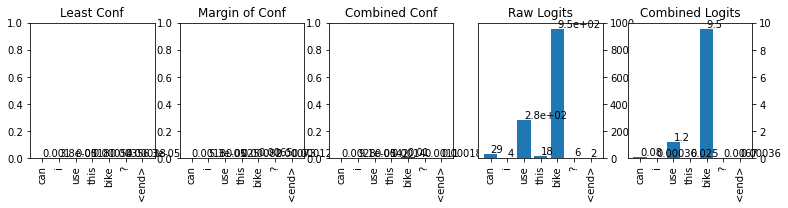

In [ ]:
# here we see the 'may' vs. 'can' uncertainty, depending on the training 
print("Target: Can I use this bike?") 
translate(u'מותר לי להשתמש באופניים?')

Target: Is anything wrong?

Input: <start> משהו לא בסדר ? <end>
Predicted translation: is something wrong ? <end> 
Runner-up translation: was everybody ok ok super 


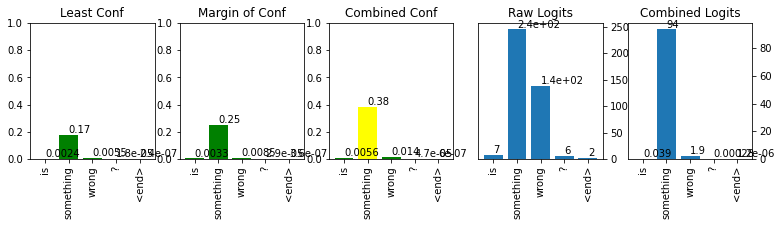

In [ ]:
#"Anything" vs. "something" vs. "anyone" uncertainty 
print("Target: Is anything wrong?")
translate(u'משהו לא בסדר?')

Target: Is this our flight?

Input: <start> זאת הטיסה שלנו ? <end>
Predicted translation: is this our flight ? <end> 
Runner-up translation: does that ours helpful . super 


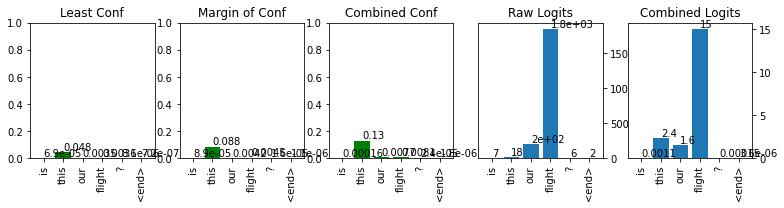

In [ ]:
 # note the "this" versus "that" uncertainty.  In my run it got "Is this our book" but "book" has very high uncertainty
 print("Target: Is this our flight?")
 translate(u'זאת הטיסה שלנו?')

Target: Stop grumbling.

Input: <start> תפסיק להתלונן . <end>
Predicted translation: stop grumbling . <end> 
Runner-up translation: quit complaining down didn't 


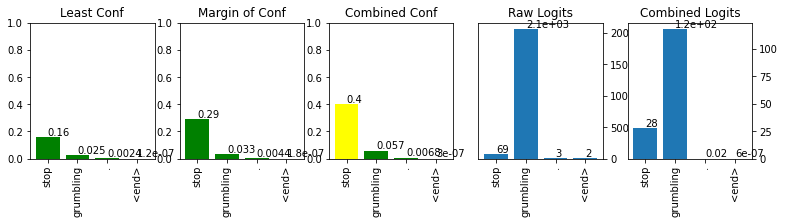

In [ ]:
# "grumbling" vs. "complaining" uncertainty sometimes, "quit" vs. "stop" sometimes
print("Target: Stop grumbling.")
translate(u'תפסיק להתלונן.')



Target: Do you see it?

Input: <start> אתה רואה את זה ? <end>
Predicted translation: do you see it ? <end> 
Runner-up translation: can i do this a ? 


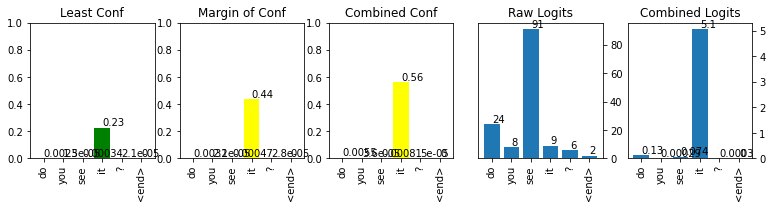

In [ ]:
#"it" versus "that", or "do" vs. <empty>
print("Target: Do you see it?")
translate(u'אתה רואה את זה?')

Target: My cat loves toys.

Input: <start> החתול שלי אוהב צעצועים <end>
Predicted translation: my cat loves toys . <end> 
Runner-up translation: i shoes trust catnip loves me 


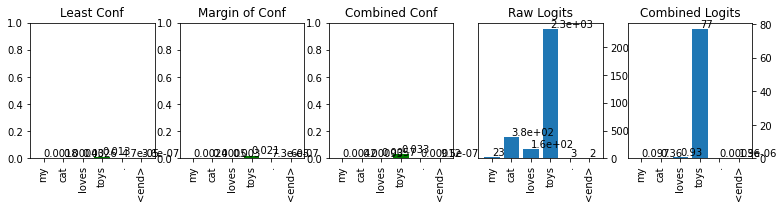

In [ ]:
print("Target: My cat loves toys.")
translate(u'החתול שלי אוהב צעצועים')

In [ ]:
#print("Target: If someone who doesn't know your background says that you sound like a native speaker, it means they probably noticed something about your speaking that made them realize you weren't a native speaker. In other words, you don't really sound like a native speaker.")
#translate(u'אם מישהו שאינו מכיר את הרקע שלכם אומר שאתם נשמעים כמו דוברים ילידים , פירוש הדבר שהוא מן הסתם הבחין במשהו בדיבורכם שגרם לו להבין שאינכם דוברים ילידים . במילים אחרות , אתם לא באמת נשמעים כמו דוברים ילידים .')


##Towards Uncertainty (and Certainty) Sampling
Now that we've seen some interesting values for individual translation tokens, we're ready to approach some uncertainty sampling using an aggregation across the entire sequence.

Let's just start with the admittedly arbitrary guess-timated thresholds below
and equally sized subsets of both our training and validation sets for testing against these thresholds.  We do want to choose these thresholds in a more sophisticated way, but for now it will do for exploration.

In [ ]:
total_test_size=1000
uncertainty_sampling_treshold = 0.5
certainty_sampling_treshold = 0.05

In [ ]:
#Some table-setting functions we'll need:

def convert_to_sentence(lang, tensor):
  sentence = "";
  for t in tensor:
    if t not in [0, 1, 2]:
      sentence = sentence + ' ' + lang.index_word[t]
  return sentence

def translate_sentences(inp_lang, targ_lang, input_tensor, target_tensor, range, verbose=True):
  scores = []
  results = []
  for s in range:
    input_sentence = convert_to_sentence(inp_lang, input_tensor[s])
    target_sentence = convert_to_sentence(targ_lang, target_tensor[s])
    if verbose:
      print("\n\nSentence: " + input_sentence)
      print("Target: " + target_sentence)
    score, result = translate(input_sentence, verbose)
    scores.append(score)
    results.append(result)
  return np.array(scores), np.array(results)


In [ ]:
def get_high_uncertainty_sample_size(sequence_mean, threshold = uncertainty_sampling_treshold):
  mask_uncertainty = sequence_mean > threshold
  uncertainty_sample = sequence_mean[mask_uncertainty]
  uncertainty_sample_size = len(uncertainty_sample)
  print("Uncertainty set size: " + str(uncertainty_sample_size) + " out of " + str(len(sequence_mean)))
  return uncertainty_sample_size

def get_low_uncertainty_sample_size(sequence_mean, threshold = certainty_sampling_treshold):
  mask_uncertainty = sequence_mean <= threshold
  certainty_sample = sequence_mean[mask_uncertainty]
  certainty_sample_size = len(certainty_sample)
  print("Certainty subset size: " + str(certainty_sample_size) + " out of " + str(len(sequence_mean)))
  return certainty_sample_size

In [ ]:
# to handle the Nan's in the scores, we have to have a custom means function
def smart_means(scores):
  #return np.mean(scores, axis=1) returns Nan when Nan present
  #np.mean(tf.boolean_mask(scores, tf.math.is_finite(scores)), axis=1) # throws error whether or not Nan present
  # TODO the below just averages the word scores.  Try using perplexity, which is the product of all the probabilities inverted, then
  # normalized by N number of words (Nth root of the above inversion)
  means = [np.mean(tf.boolean_mask(sentence, tf.math.is_finite(sentence))) for sentence in scores] 
  return np.array(means) 

In [ ]:
#val = train_score_plots[0,:,3]
val = [5, 15, 5, 15, 5, 15, np.nan]
val_list = [val, val, [6,3, np.nan]]
print(val_list)
#boolean_mask = tf.cast(val, dtype=tf.bool)              
##no_zeros = tf.boolean_mask(val, boolean_mask)
##non_zeros = val[val.nonzero()]
#print(non_zeros)
#print(np.mean(tf.boolean_mask(val_list, tf.math.is_finite(val_list))))
#print(tf.math.reduce_mean(val).numpy())
print(smart_means(val_list))
#training_information_means[0:10]

[[5, 15, 5, 15, 5, 15, nan], [5, 15, 5, 15, 5, 15, nan], [6, 3, nan]]
[10.  10.   4.5]


Depending on the size of the test (above) the two cells below  may take a minute or two each for 1000 translations on a GPU.   

In [ ]:

train_score_plots, training_results = translate_sentences(inp_lang, targ_lang, input_tensor_train, target_tensor_train, range(total_test_size), verbose=False)
#print(train_score_plots.shape) #(1000, 10, 4)
train_score_plots_ragged = tf.ragged.boolean_mask(train_score_plots, tf.math.is_finite(train_score_plots))
#print(train_score_plots_ragged.shape) (1000, None, None)
#print(tf.ragged.boolean_mask(train_score_plots, tf.math.is_finite(train_score_plots)).shape) (1000, None, None)
train_set_mean = tf.math.reduce_mean(train_score_plots_ragged, axis=[0,1]) 
#print("train_set shape " + str(train_set_mean.shape)) (5,)
print("Training set competition uncertainty means: " + str(train_set_mean[:3].numpy()))
print("Training set information means: " + str(train_set_mean[3:].numpy()))
training_sequences_means = smart_means(train_score_plots[:,:,2]) #sequence mean as our sample aggregation function TODO consider using minimum
#training_sequences_means = tf.math.reduce_mean(train_score_plots[:,:,2], axis=1) #doesn't work with ragged tensors
training_information_means = smart_means(train_score_plots[:,:,3])
training_combined_means = smart_means(train_score_plots[:,:,4])
training_high_uncertainty_sample_size = get_high_uncertainty_sample_size(training_sequences_means)
training_low_uncertainty_sample_size = get_low_uncertainty_sample_size(training_sequences_means)

Training set competition uncertainty means: [0.0231594  0.03859755 0.05124152]
Training set information means: [256.43086019  20.42204682]
Uncertainty set size: 2 out of 1000
Certainty subset size: 700 out of 1000


In [ ]:
val_score_plots, val_results = translate_sentences(inp_lang, targ_lang, input_tensor_val, target_tensor_val, range(total_test_size), verbose=False)
val_score_plots_ragged = tf.ragged.boolean_mask(val_score_plots, tf.math.is_finite(val_score_plots))
val_set_mean = tf.math.reduce_mean(val_score_plots_ragged, axis=[0,1])
print("Validation set uncertainty means: " + str(val_set_mean[:3].numpy()))
print("Validation set information means: " + str(val_set_mean[3:].numpy()))
val_sequences_means = smart_means(val_score_plots[:,:,2]) #sequence mean as our sample aggregation function
val_information_means = smart_means(val_score_plots[:,:,3])
val_combined_means = smart_means(val_score_plots[:,:,4])
val_high_uncertainty_sample_size = get_high_uncertainty_sample_size(val_sequences_means)
val_low_uncertainty_sample_size = get_low_uncertainty_sample_size(val_sequences_means)


Validation set uncertainty means: [0.09146347 0.13527442 0.16651913]
Validation set information means: [224.6946945   99.33516962]
Uncertainty set size: 23 out of 1000
Certainty subset size: 281 out of 1000


Not surprisingly:
* the overall uncertainty means across all three measures are higher for the validation set
* the "certain" cohort is larger for the training set versus the validation set.

A little more suprisingly:
* while the above remains true, for the same thresholds, different "slices" of 1000 out of our total training and validation sets can yield different total #'s and 'uncertain' vs. 'certain' cohorts.  We'll explore that below.
* the overall raw logits means are about the same for both the validation and training sets.  (However, combined not surprisingly when combined with the combined confidence, the score is much higher for the validation set.)

### Exploring Underfitting and (Un)certainty
So to look for avoidable bias (underfitting), now let's take a look at which of our confident mis-matches (at least according to our crude 1-1 matching algorithm with no alternate reference translations considered):

In [ ]:

def get_ranked_uncertainty(sequences_means, size, target_tensor=None, input_tensor=None, 
                           direction='DESCENDING', display=True, ranking=None, results=None,  targ_lang=targ_lang):
  matches = []
  non_matches = []
  if ranking is None:
    ranking = tf.argsort(sequences_means, direction=direction)
  for u in range(size):
    #print(ranking[u]) 
    target = convert_to_sentence(targ_lang, target_tensor[ranking[u]])
    #print("\n\nTarget: " + target)
    if display:
      print("\n\nTarget: " + target)
      print("Aggregate Score (mean): " + str(sequences_means[ranking[u]]))
      translate(convert_to_sentence(inp_lang, input_tensor[ranking[u]]))
    else:
      tokenized_result = results[ranking[u]] #_, tokenized_result = translate(convert_to_sentence(inp_lang, input_tensor[ranking[u]]), verbose=False)
      if "<end>" in tokenized_result:
        tokenized_result.remove('<end>')
      if ' '.join(tokenized_result).strip() == target.strip():
        matches.append(ranking[u])
      else:
        #print(' '.join(tokenized_result).strip()) #- if you want to display the non-match inline
        #print(target.strip())
        non_matches.append(ranking[u])
  return np.array(matches), np.array(non_matches)


In [ ]:
training_matches, training_non_matches = get_ranked_uncertainty(training_sequences_means, training_low_uncertainty_sample_size, target_tensor_train,
                                              direction='ASCENDING', display=False, results=training_results)
#print(training_matches[-1])
print("Training set confident matches: " + str(len(training_matches)))
print("Training set confident non-Matches: " + str(len(training_non_matches)))
print("Matching: {:.1%}".format((len(training_matches)/(len(training_matches)+len(training_non_matches)))))

Training set confident matches: 691
Training set confident non-Matches: 9
Matching: 98.7%


Yay!  A high percentage of matches (accuracy) in the large highly confident set is what we like to see.  Let's look at the non-matches:



Target:  i felt fine .
Aggregate Score (mean): 0.0028940677642822266

Input: <start> חשתי בטוב . <end>
Predicted translation: i felt good . <end> 
Runner-up translation: i've feels fine shoes . 


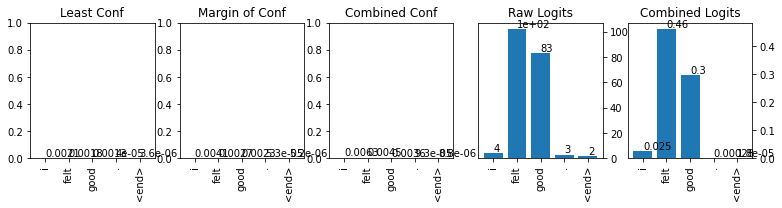



Target:  tom became irate .
Aggregate Score (mean): 0.009863364696502685

Input: <start> תום התחיל להתעצבן . <end>
Predicted translation: tom became angry . <end> 
Runner-up translation: tom's was irate then . 


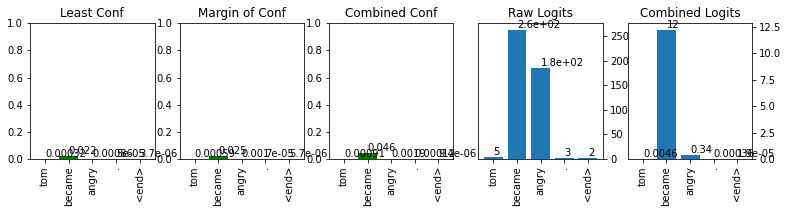



Target:  can you find it ?
Aggregate Score (mean): 0.013239999612172445

Input: <start> תוכל למצוא אותה ? <end>
Predicted translation: can you find her ? <end> 
Runner-up translation: could i help it . you 


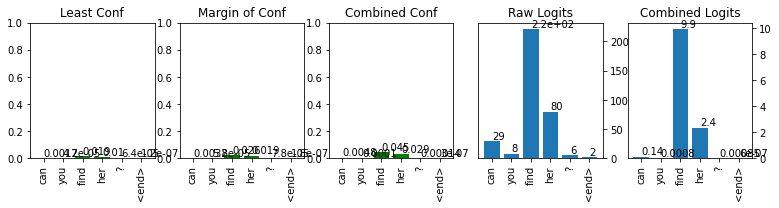



Target:  which hat is yours ?
Aggregate Score (mean): 0.015144675970077515

Input: <start> איזה כובע שלך ? <end>
Predicted translation: which cap is yours ? <end> 
Runner-up translation: what is has he . ? 


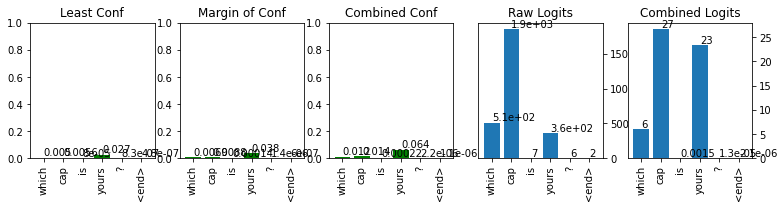



Target:  he's coming .
Aggregate Score (mean): 0.020854198932647706

Input: <start> הנה הוא בא . <end>
Predicted translation: here he comes . <end> 
Runner-up translation: he's comes is closer . 


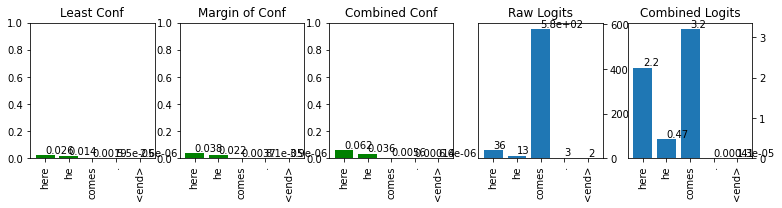



Target:  hi . how are you ?
Aggregate Score (mean): 0.028945437499455044

Input: <start> שלום , מה שלומך ? <end>
Predicted translation: hi , how's it going ? <end> 
Runner-up translation: how's it hi this ? , how 


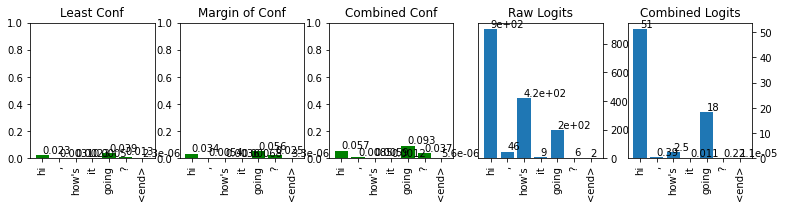



Target:  tom must find work .
Aggregate Score (mean): 0.03281761918749128

Input: <start> תום חייב למצוא עבודה . <end>
Predicted translation: tom must find a job . <end> 
Runner-up translation: he should have work car job me 


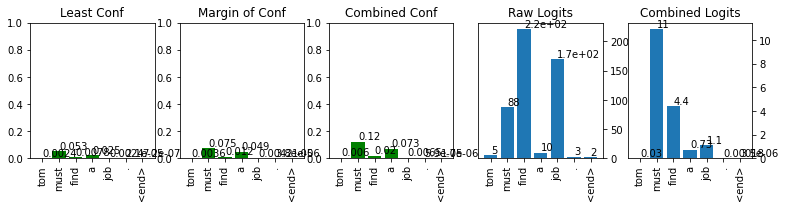



Target:  that happened here .
Aggregate Score (mean): 0.041033828258514406

Input: <start> זה קרה כאן . <end>
Predicted translation: it happened here . <end> 
Runner-up translation: that is ! ! super 


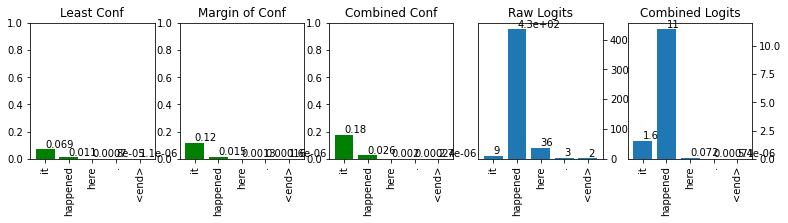



Target:  tom wants that .
Aggregate Score (mean): 0.04173232316970825

Input: <start> תום רוצה את זה . <end>
Predicted translation: tom wants this . <end> 
Runner-up translation: that has that job . 


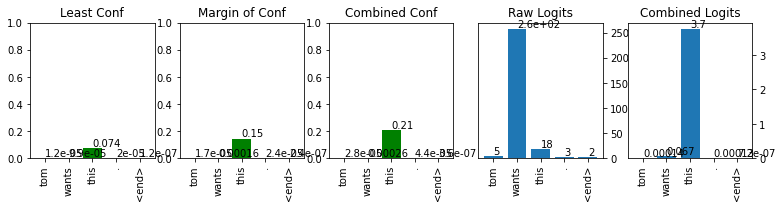

(array([], dtype=float64), array([], dtype=float64))

In [ ]:
get_ranked_uncertainty(training_sequences_means, len(training_non_matches), target_tensor_train, 
                       input_tensor=input_tensor_train, ranking=training_non_matches, results=training_results)

OK!  Some of these departures from the strict ground truth would probably qualify as alternate reference translations, or even better translations.  (There also seems to be an issue where the model doesn't "know" that it has an issue with tense, so there's an area to target for underfitting.) 

Overall, for our set of sentences with a high "certainty" threshold of 0.02, the size can range widely from 28% to just over 63% of the training set!.  But no matter its size (keep in mind this is so far a fairly arbitrary threshold) we are pretty close to fully fitting for this high confidence level.  

Before we get too full of ourselves and forget what we're really after in an Active Learning cycle, let's look at the least confident ones, and along the way try to find some examples of underfitting:




In [ ]:
training_unsure_matches, training_unsure_non_matches = get_ranked_uncertainty(training_sequences_means, training_high_uncertainty_sample_size, target_tensor_train,
                                              display=False, results=training_results)
print("Training set highly non-confident matches: " + str(len(training_unsure_matches)))
print("Training set highly non-confident non-Matches: " + str(len(training_unsure_non_matches)))

Training set highly non-confident matches: 0
Training set highly non-confident non-Matches: 2




Target:  i don't like movies .
Aggregate Score (mean): 0.5895752945914865

Input: <start> אני לא אוהב סרטים . <end>
Predicted translation: i dislike likes . <end> 
Runner-up translation: i'd don't not sight me 


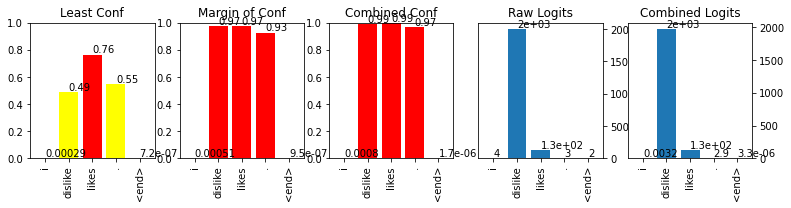



Target:  the crowd groaned .
Aggregate Score (mean): 0.5143212370574475

Input: <start> הקהל רטן . <end>
Predicted translation: slow down grumbled . <end> 
Runner-up translation: the fainted pushing groaned . 


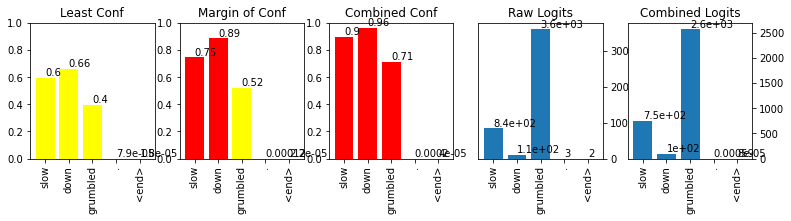

(array([], dtype=float64), array([], dtype=float64))

In [ ]:
get_ranked_uncertainty(training_sequences_means, len(training_unsure_non_matches), target_tensor_train, 
                       input_tensor=input_tensor_train, ranking=training_unsure_non_matches, results=training_results)

Alright, a few issues here among the low certainty cohort.  Not all of these are bad translations in one set I ran "He's not home" becomes "He isn't at home", or "Let me out!" becomes "I want to leave!" 

Its interesting to note sometimes which individual words/tokens will have high uncertainty, often indicating where the translation went awry.  This could be of help for humans in the loop correcting these translations, for example.  

But let's be hard on ourselves and assume they're all one way or another examples of underfitting - at least finding them by means of low aggregate uncertainty ranking.  Now we'd have to candidates for an Active Learning cycle.  Also, playing with the thresholds (and ultimately, optimizing them) would be the next thing to try in future cycles.  Before we move on to the validation set, let's glance at the "low information" raw logits outputs at the last layer of our network:



Target:  here's tom .
Aggregate Score (mean): 11.5

Input: <start> הנה תום . <end>
Predicted translation: here tom . <end> 
Runner-up translation: here's they is . 


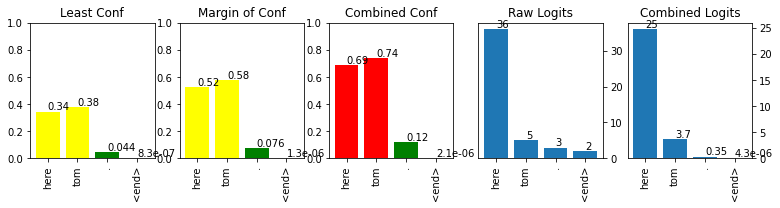



Target:  is it here ?
Aggregate Score (mean): 12.0

Input: <start> האם זה כאן ? <end>
Predicted translation: is it here ? <end> 
Runner-up translation: does that a yet super 


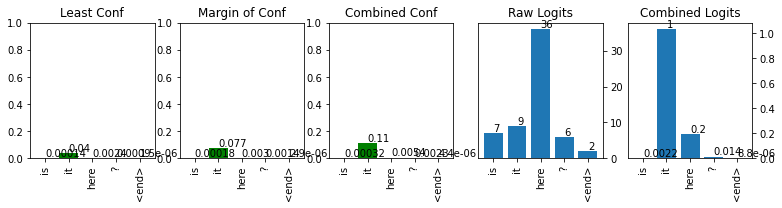



Target:  we like tom .
Aggregate Score (mean): 12.0

Input: <start> אנו מחבבים את תום . <end>
Predicted translation: we like tom . <end> 
Runner-up translation: we've dig boston is tom 


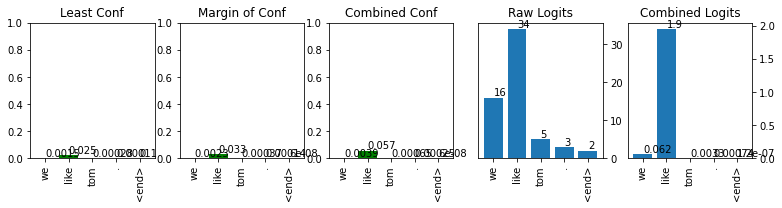



Target:  i need you .
Aggregate Score (mean): 12.0

Input: <start> אני צריך אותך . <end>
Predicted translation: i need you . <end> 
Runner-up translation: i've have to quit you 


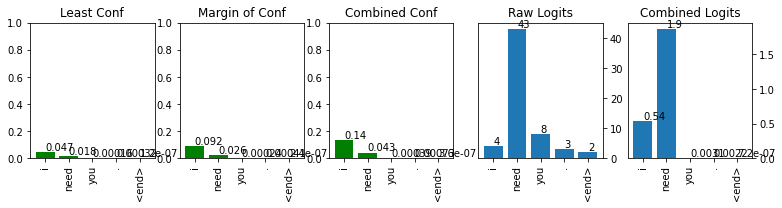



Target:  i don't need you .
Aggregate Score (mean): 13.166666666666666

Input: <start> אני לא צריך אותך . <end>
Predicted translation: i don't need you . <end> 
Runner-up translation: i'm dislike care no care you 


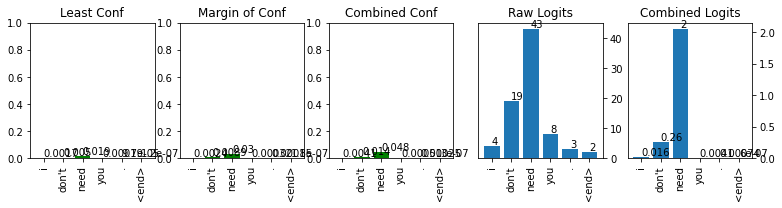



Target:  there you are .
Aggregate Score (mean): 13.8

Input: <start> הנה את . <end>
Predicted translation: here you are . <end> 
Runner-up translation: there ? know the . 


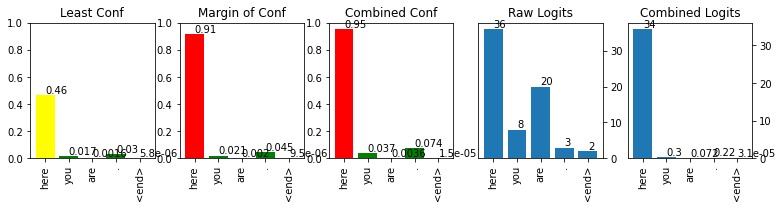



Target:  you can go .
Aggregate Score (mean): 14.8

Input: <start> את יכולה ללכת . <end>
Predicted translation: you can go . <end> 
Runner-up translation: you're may walk going . 


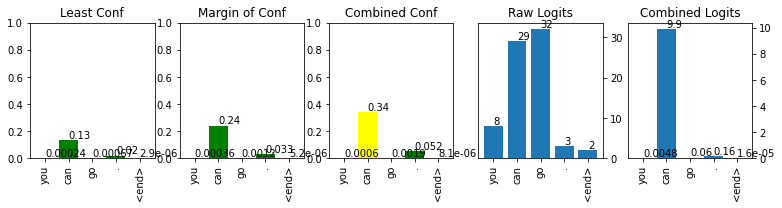



Target:  i don't get you .
Aggregate Score (mean): 15.333333333333334

Input: <start> אינני מבינה אותך . <end>
Predicted translation: i don't get you . <end> 
Runner-up translation: i'm never understand summer so i 


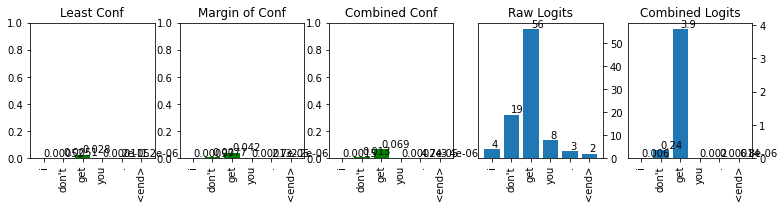



Target:  we are here .
Aggregate Score (mean): 15.4

Input: <start> אנחנו כאן . <end>
Predicted translation: we are here . <end> 
Runner-up translation: here will new ! super 


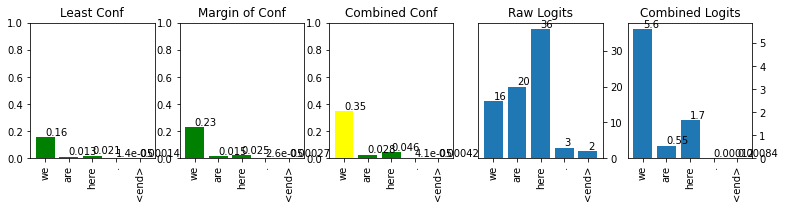



Target:  what was that ?
Aggregate Score (mean): 16.0

Input: <start> מה זה היה ? <end>
Predicted translation: what was that ? <end> 
Runner-up translation: why is it was me 


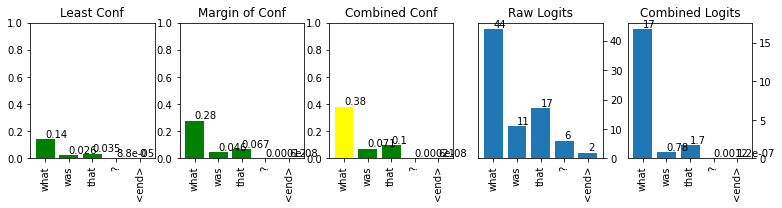

(array([], dtype=float64), array([], dtype=float64))

In [ ]:
get_ranked_uncertainty(training_information_means, 10, target_tensor_train, 
                       input_tensor=input_tensor_train, direction='ASCENDING', results=training_results)


Nothing too interesting here, mostly some confusion among common vocabular like "this"/"that" and the like.

### Exploring Variance and (Un)certainty


Previously we saw that the validation results had fewer high confidence examples.  Let's start by looking at those:


In [ ]:
val_conf_matches, val_conf_non_matches = get_ranked_uncertainty(val_sequences_means, val_low_uncertainty_sample_size, target_tensor_val,
                                              direction='ASCENDING', display=False, results=val_results)
print("Validation set confident matches: " + str(len(val_conf_matches)))
print("Validation set confident non-matches: " + str(len(val_conf_non_matches)))
print("Matching: {:.1%}".format((len(val_conf_matches)/(len(val_conf_matches)+len(val_conf_non_matches)))))

Validation set confident matches: 193
Validation set confident non-matches: 88
Matching: 68.7%


Usually we have fewer overall high-certainty results from the validation set compared with the training set (using the same threshold as training). (However, some n-1000 test batches I've run happen to match or even exceed the training set!) 

It's also not surprising that we have a higher number of confident non-Matches.  As we did before, let's check out those high certainty non-matches:

In [ ]:
get_ranked_uncertainty(val_sequences_means, len(val_conf_non_matches), target_tensor_val, 
                       input_tensor=input_tensor_val, ranking=val_conf_non_matches, results=val_results)

The majority of these are decent alternate translations, and again uncovers issues where MT result is better than the "ground truth" e.g. in my set the translation "i'm here" is better than "I'm in here". So, it's kind of cool to see it generalizing in a correct way. We'll explore this more below. 

Let's look at the larger least confident cohort:

In [ ]:
val_unsure_matches, val_unsure_non_matches = get_ranked_uncertainty(val_sequences_means, val_high_uncertainty_sample_size, target_tensor_val,
                                              display=False, results=val_results)
print("Validation set highly non-confident matches: " + str(len(val_unsure_matches)))
print("Validation set highly non-confident non-Matches: " + str(len(val_unsure_non_matches)))
print("Matching: {:.1%}".format(len(val_unsure_matches)/(len(val_unsure_matches)+len(val_unsure_non_matches))))

Validation set highly non-confident matches: 0
Validation set highly non-confident non-Matches: 23
Matching: 0.0%




Target:  i didn't go crazy .
Aggregate Score (mean): 0.6577186822891236

Input: <start> לא יצאתי מדעתי . <end>
Predicted translation: you didn't go . <end> 
Runner-up translation: i went lie crazy . 


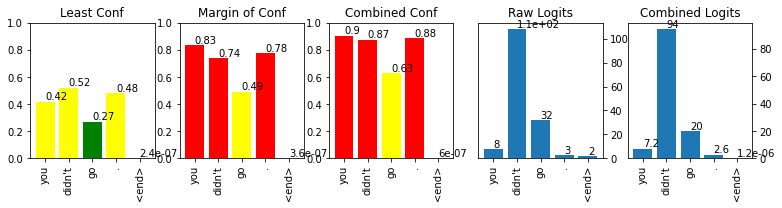



Target:  get in here quick .
Aggregate Score (mean): 0.635750382731203

Input: <start> הכנס לכאן מהר . <end>
Predicted translation: step here . <end> 
Runner-up translation: come back quick go 


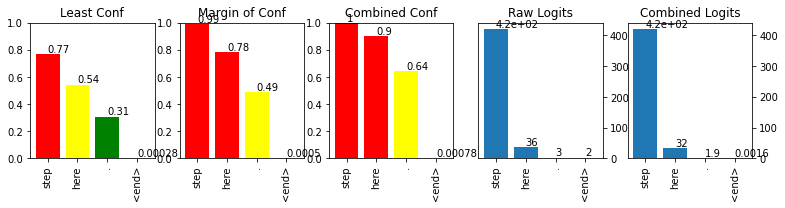



Target:  try on that shirt .
Aggregate Score (mean): 0.6109447710216045

Input: <start> תמדדי את החולצה ההיא . <end>
Predicted translation: try that area . <end> 
Runner-up translation: think on shirt once did 


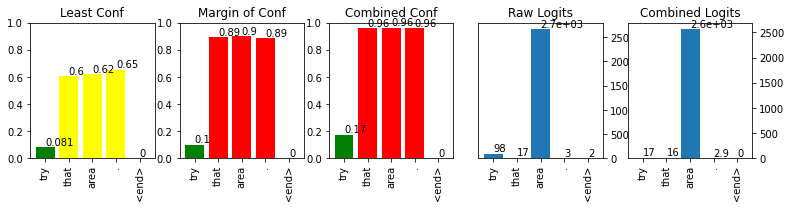



Target:  how much is that ?
Aggregate Score (mean): 0.599285862594843

Input: <start> מה המחיר של זה ? <end>
Predicted translation: what's is it ? <end> 
Runner-up translation: what tom's that is ? 


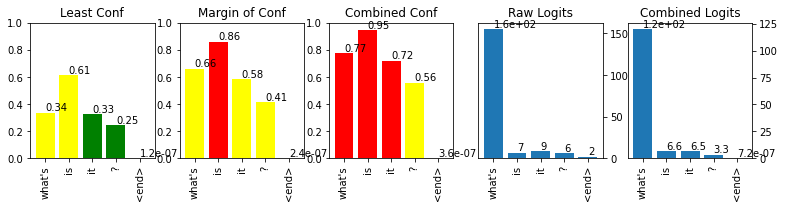



Target:  who else was there ?
Aggregate Score (mean): 0.5918581798672676

Input: <start> מי עוד היה שם ? <end>
Predicted translation: who was there ? <end> 
Runner-up translation: who's is over , ? 


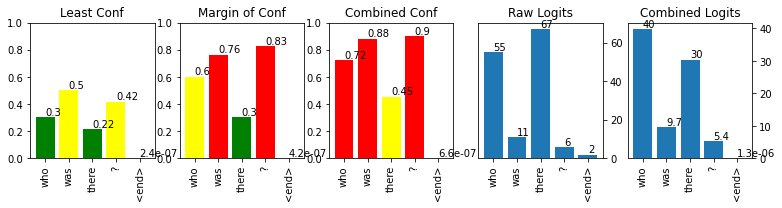



Target:  congratulations !
Aggregate Score (mean): 0.5881731834029779

Input: <start> ברכותיי ! <end>
Predicted translation: good is up ! <end> 
Runner-up translation: attack ! out . ! 


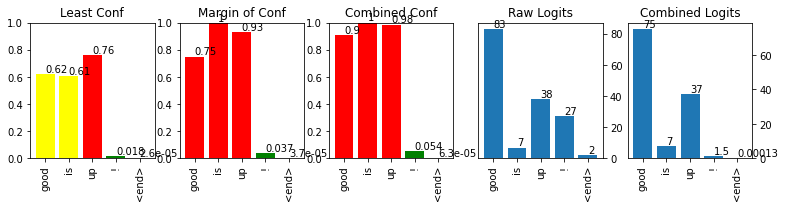



Target:  thanks a million .
Aggregate Score (mean): 0.5842757585148016

Input: <start> רוב תודות ! <end>
Predicted translation: thanks a shame off . <end> 
Runner-up translation: let's an million ! ! super 


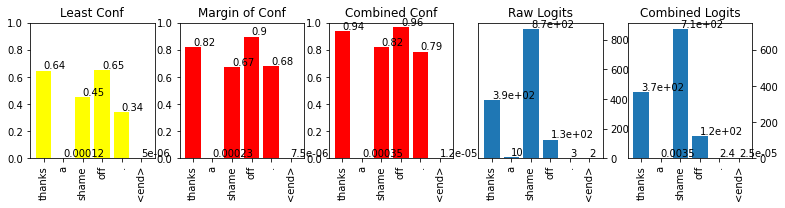



Target:  i give you my word .
Aggregate Score (mean): 0.5798463110501567

Input: <start> זו מילת הכבוד שלי . <end>
Predicted translation: it is a lot . <end> 
Runner-up translation: it's goes you bad of me 


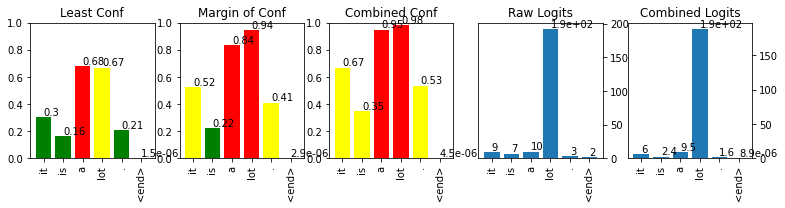



Target:  i cheered .
Aggregate Score (mean): 0.5651012227870524

Input: <start> הריעתי . <end>
Predicted translation: i will translate . <end> 
Runner-up translation: i've got survive ! . 


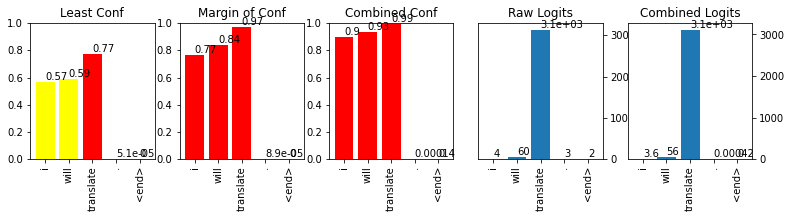



Target:  it's like this .
Aggregate Score (mean): 0.5569796182015645

Input: <start> ובכן , זה כך . <end>
Predicted translation: this is it is that . <end> 
Runner-up translation: that's will this i it ! it 


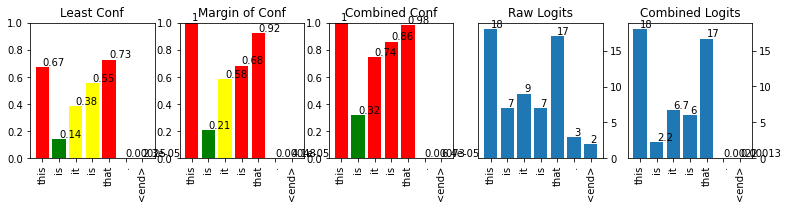



Target:  i'm sorry you lost .
Aggregate Score (mean): 0.5558371876499483

Input: <start> אני מצטערת שהפסדת . <end>
Predicted translation: i'm afraid to the zoo . <end> 
Runner-up translation: i'll suspicious you lost car ! me 


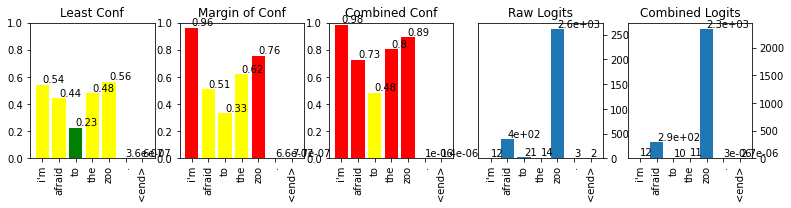



Target:  i became angry .
Aggregate Score (mean): 0.5541586631909012

Input: <start> התכעסתי . <end>
Predicted translation: i will obey . <end> 
Runner-up translation: i'll got translate ! . 


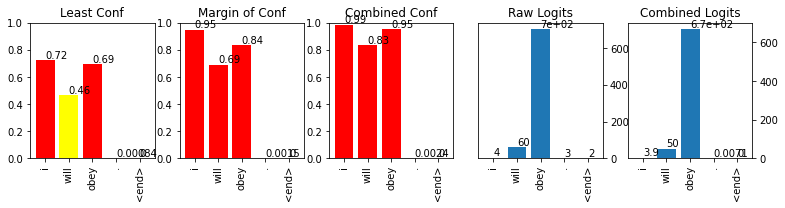



Target:  copy this file .
Aggregate Score (mean): 0.5484924763441086

Input: <start> העתק את הקובץ הזה . <end>
Predicted translation: rugs this box . <end> 
Runner-up translation: copy that area later . 


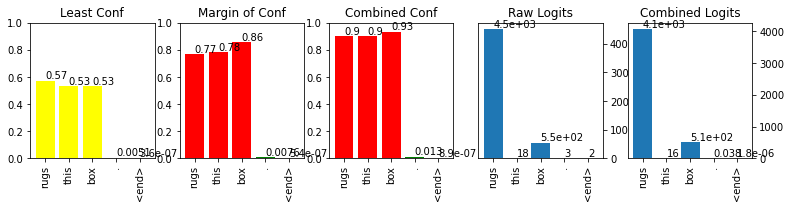



Target:  i hesitated .
Aggregate Score (mean): 0.5472688969224692

Input: <start> היססתי . <end>
Predicted translation: i will translate . <end> 
Runner-up translation: we got obey ! . 


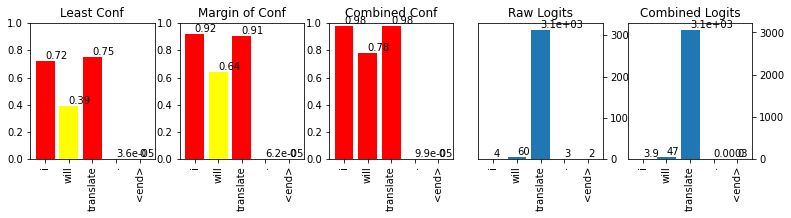



Target:  settle down !
Aggregate Score (mean): 0.5454199001193046

Input: <start> ישבו את המחלוקת ! <end>
Predicted translation: put your hand ! <end> 
Runner-up translation: give out mouth . didn't 


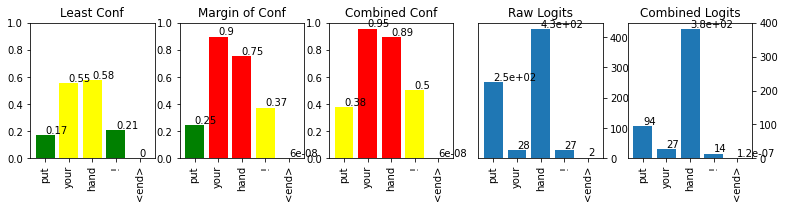



Target:  i was hunting .
Aggregate Score (mean): 0.5372847883030772

Input: <start> צדתי . <end>
Predicted translation: i was lying . <end> 
Runner-up translation: i've will hunting ! super 


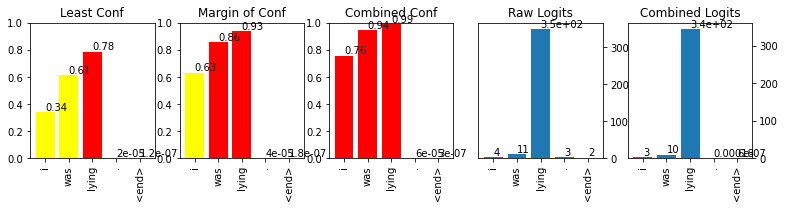



Target:  after you .
Aggregate Score (mean): 0.5337464921176434

Input: <start> בבקשה , יופי לפני גיל . <end>
Predicted translation: please come to me . <end> 
Runner-up translation: wait work ! work ! super 


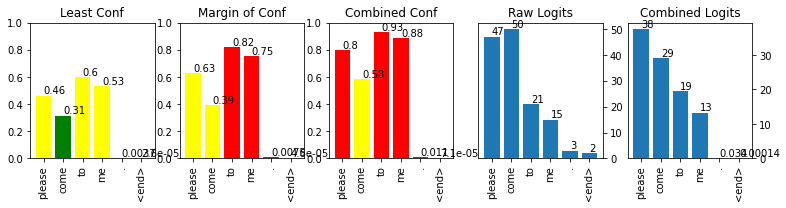



Target:  i'll manage .
Aggregate Score (mean): 0.5336774617433548

Input: <start> אנהל . <end>
Predicted translation: i will obey . <end> 
Runner-up translation: i'll got translate ! . 


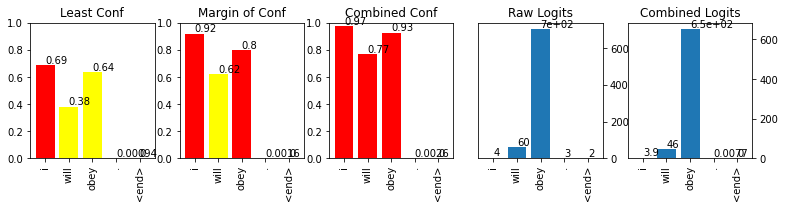



Target:  that's much worse .
Aggregate Score (mean): 0.5334297837301468

Input: <start> זה הרבה יותר גרוע . <end>
Predicted translation: that's a bad movie . <end> 
Runner-up translation: this way lot . is . 


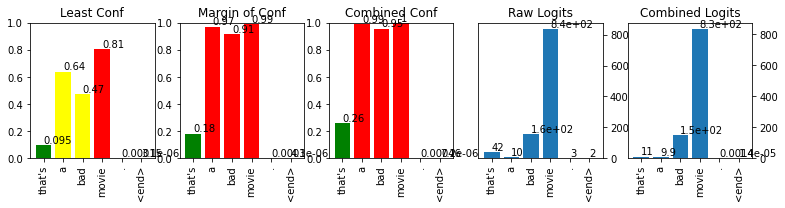



Target:  he's open-minded .
Aggregate Score (mean): 0.5258889243006706

Input: <start> יש לו ראש פתוח . <end>
Predicted translation: he's an feet . <end> 
Runner-up translation: he open-minded boys man fuji 


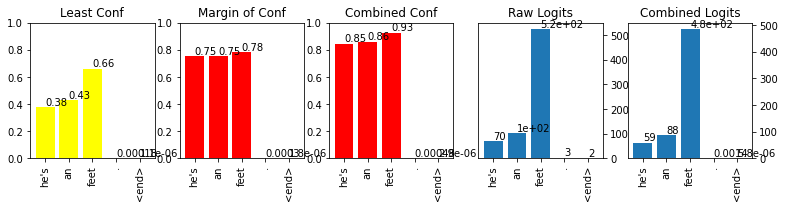



Target:  cherish this moment .
Aggregate Score (mean): 0.517806407622993

Input: <start> הוקיר את הרגע . <end>
Predicted translation: cherish the shirt . <end> 
Runner-up translation: write this nail down myself 


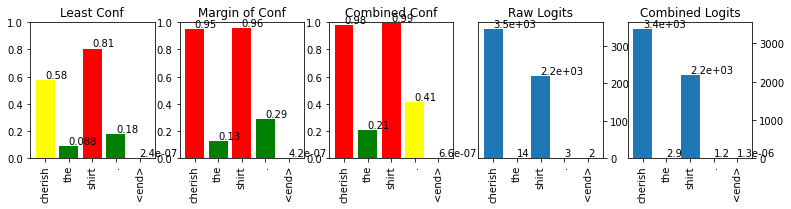



Target:  how long are they ?
Aggregate Score (mean): 0.5109089203178883

Input: <start> מה אורכם ? <end>
Predicted translation: how's the car ? <end> 
Runner-up translation: how that matter doing i 


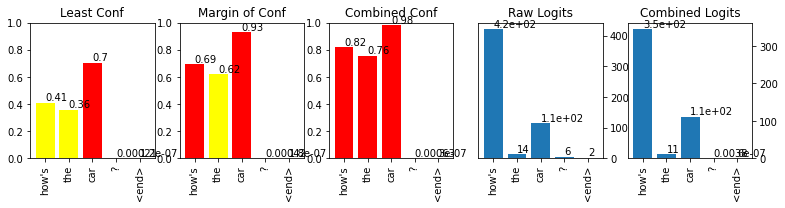



Target:  what a big truck !
Aggregate Score (mean): 0.5058060403913259

Input: <start> הנה משאית ענקית ! <end>
Predicted translation: here he big ! <end> 
Runner-up translation: family is died baseball die 


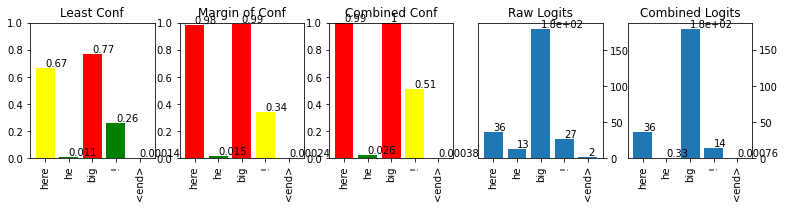

(array([], dtype=float64), array([], dtype=float64))

In [ ]:
get_ranked_uncertainty(val_sequences_means, len(val_unsure_non_matches), target_tensor_val, 
                       input_tensor=input_tensor_val, ranking=val_unsure_non_matches, results=val_results)

Wow!  Pretty bad stuff there - but that was exactly what we were looking for as candidates for a first pass in an Active Learning cycle.  Also, it shows that the model is aware of its "known unknowns".  Finally, let's touch on the overall look of the validation set apart from the high uncertainty set:

In [ ]:
val_matches, val_non_matches = get_ranked_uncertainty(val_sequences_means, total_test_size-val_high_uncertainty_sample_size, target_tensor_val,
                                              direction='ASCENDING', display=False, results=val_results)
print("Validation set less confused matches: " + str(len(val_matches)))
print("Validation set less confused non-Matches: " + str(len(val_non_matches)))
print("Matching: {:.1%}".format((len(val_matches)/(len(val_matches)+len(val_non_matches)))))

Validation set less confused matches: 456
Validation set less confused non-Matches: 521
Matching: 46.7%


In various runs, I range from about 23% to even 75% matching, and therefore known to be accurate - much better than our highly uncertain set.  And of course, many of these non-matches may be viable translations.  Exploring and optimizing the thresholds should help, so let's try a different way of discovering non-matches (and, among those, errors) by using low information content of the raw logits:



Target:  was he tom ?
Aggregate Score (mean): 7.4

Input: <start> הוא היה תום ? <end>
Predicted translation: was he tom ? <end> 
Runner-up translation: is tom was was ? 


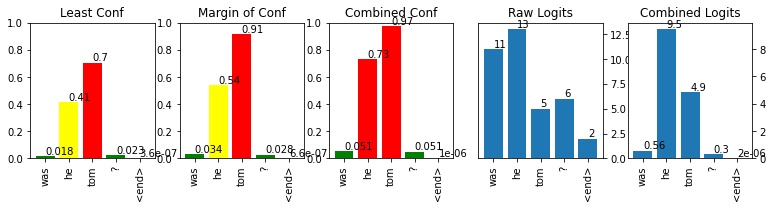



Target:  that's them .
Aggregate Score (mean): 7.8

Input: <start> זה הם . <end>
Predicted translation: this is it . <end> 
Runner-up translation: that's will nuts ! super 


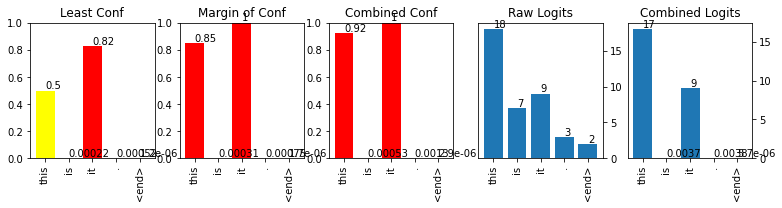



Target:  it's like this .
Aggregate Score (mean): 9.0

Input: <start> ובכן , זה כך . <end>
Predicted translation: this is it is that . <end> 
Runner-up translation: that's will this i it ! it 


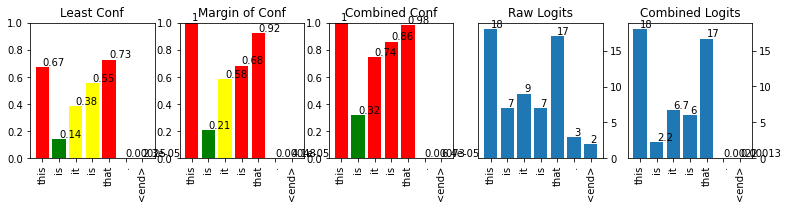



Target:  i need this .
Aggregate Score (mean): 12.2

Input: <start> אני זקוק לזה . <end>
Predicted translation: i need it . <end> 
Runner-up translation: i've needs this to it 


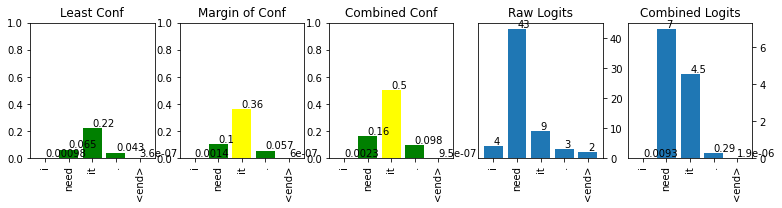



Target:  i love movies .
Aggregate Score (mean): 12.2

Input: <start> אני אוהב קולנוע . <end>
Predicted translation: i like this . <end> 
Runner-up translation: i've love crowds color . 


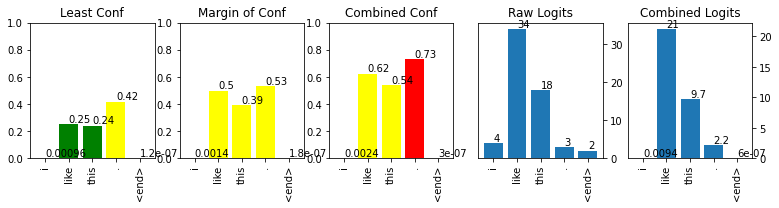



Target:  this is tom .
Aggregate Score (mean): 13.0

Input: <start> זה תום . <end>
Predicted translation: that's tom . <end> 
Runner-up translation: this insulting is tom 


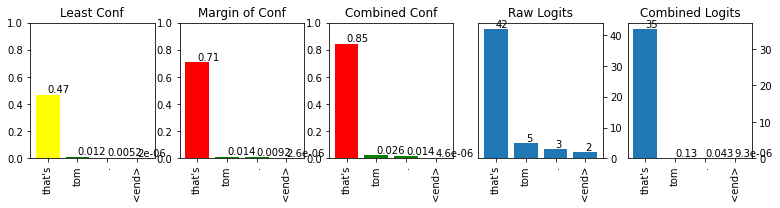



Target:  you can make it .
Aggregate Score (mean): 13.833333333333334

Input: <start> אתה יכול לעשות את זה . <end>
Predicted translation: you can do that . <end> 
Runner-up translation: it could be it ? it 


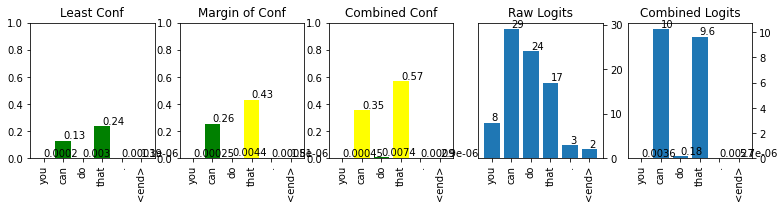



Target:  they can do it .
Aggregate Score (mean): 15.5

Input: <start> הם יכולים לעשות את זה . <end>
Predicted translation: they can do it . <end> 
Runner-up translation: everyone could have that is . 


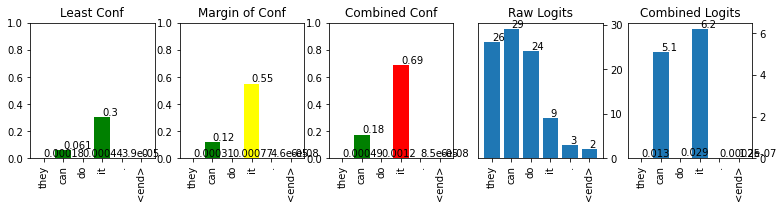



Target:  they need tom .
Aggregate Score (mean): 15.8

Input: <start> הם צריכים את תום . <end>
Predicted translation: they need tom . <end> 
Runner-up translation: we should them away . 


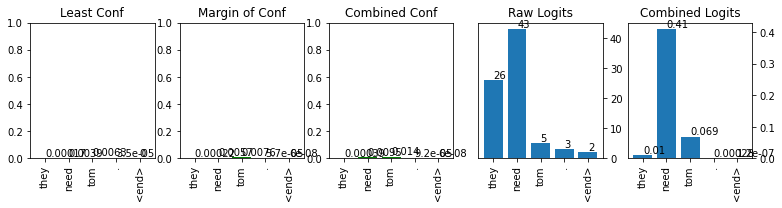



Target:  we love you .
Aggregate Score (mean): 16.0

Input: <start> אנו אוהבים אותך . <end>
Predicted translation: we love you . <end> 
Runner-up translation: we've like love love . 


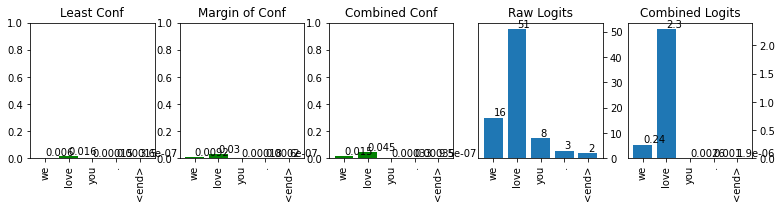



Target:  you need to leave .
Aggregate Score (mean): 16.0

Input: <start> אתה צריך ללכת . <end>
Predicted translation: you have to go . <end> 
Runner-up translation: you've must some leave going go 


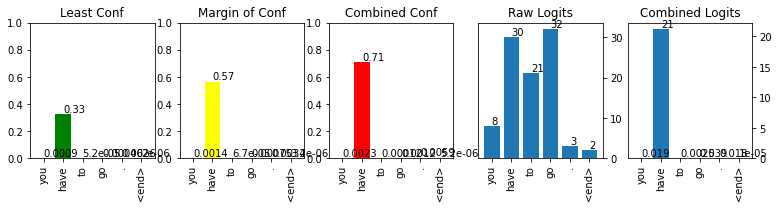



Target:  you're here .
Aggregate Score (mean): 16.5

Input: <start> אתם פה . <end>
Predicted translation: you're here . <end> 
Runner-up translation: you home ! fire 


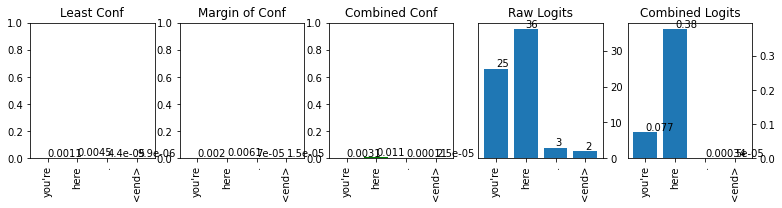



Target:  that's all it was .
Aggregate Score (mean): 18.0

Input: <start> זה כל מה שזה היה . <end>
Predicted translation: this is all it was . <end> 
Runner-up translation: that's isn't that this . ! . 


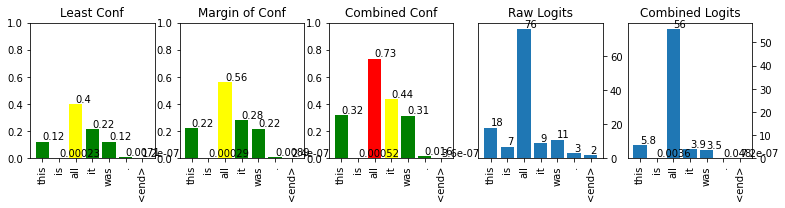



Target:  we know this .
Aggregate Score (mean): 18.2

Input: <start> אנחנו יודעים את זה . <end>
Predicted translation: we know this . <end> 
Runner-up translation: we've knows that is . 


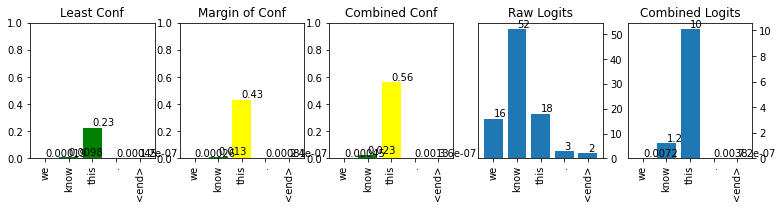



Target:  who was that ?
Aggregate Score (mean): 18.2

Input: <start> מי זה היה ? <end>
Predicted translation: who was that ? <end> 
Runner-up translation: why is it was ? 


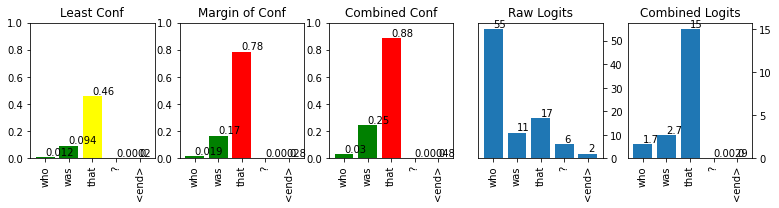



Target:  we know tom did it .
Aggregate Score (mean): 18.285714285714285

Input: <start> אנחנו יודעים שתום עשה זאת . <end>
Predicted translation: we know tom did it . <end> 
Runner-up translation: they knows that do this is did 


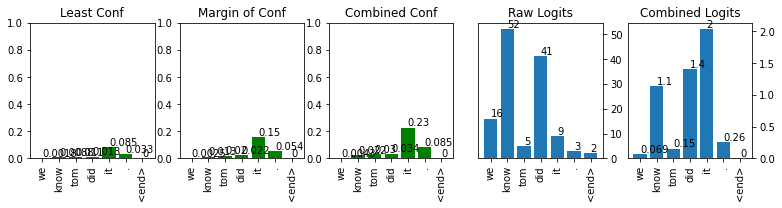



Target:  did you do it ?
Aggregate Score (mean): 18.5

Input: <start> אתה עשית את זה ? <end>
Predicted translation: did you did you do this ? <end> 
Runner-up translation: do i do this ? it you ? 


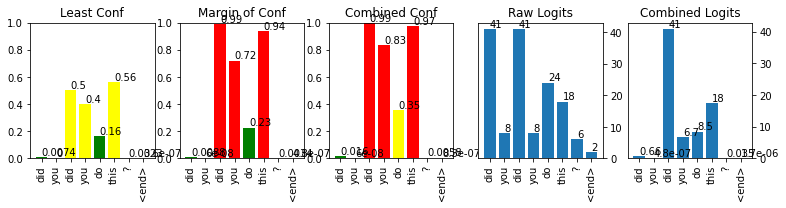



Target:  we did it !
Aggregate Score (mean): 19.0

Input: <start> הצלחנו ! <end>
Predicted translation: we did it ! <end> 
Runner-up translation: we'll needed ! . didn't 


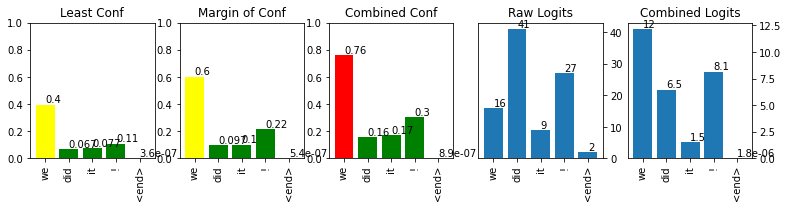



Target:  how do you manage ?
Aggregate Score (mean): 19.0

Input: <start> איך את מסתדרת ? <end>
Predicted translation: how are you do ? <end> 
Runner-up translation: how's do your doing you ? 


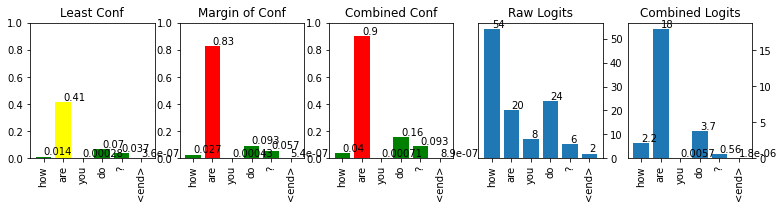



Target:  i like it very much .
Aggregate Score (mean): 20.0

Input: <start> אני מאוד אוהבת את זה . <end>
Predicted translation: i love love it . <end> 
Runner-up translation: i'd like like that very it 


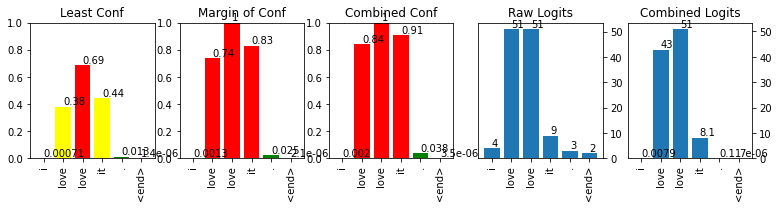



Target:  may i assist you ?
Aggregate Score (mean): 20.0

Input: <start> אני יכול לעזור לך ? <end>
Predicted translation: can i help you ? <end> 
Runner-up translation: may you assist us here you 


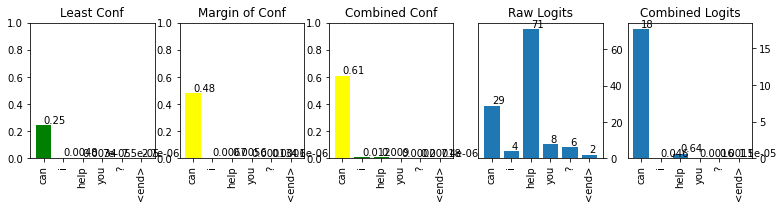



Target:  this is for you .
Aggregate Score (mean): 20.5

Input: <start> זה למענך . <end>
Predicted translation: this is for you . <end> 
Runner-up translation: it's for an me won super 


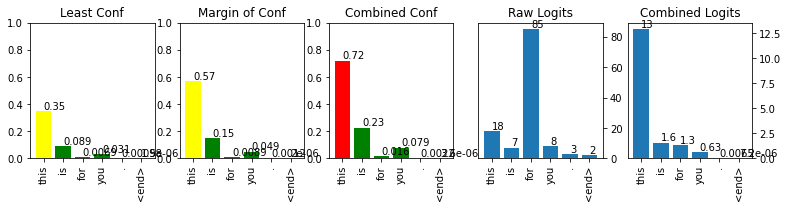



Target:  how do they do it ?
Aggregate Score (mean): 20.714285714285715

Input: <start> כיצד הם עושים את זה ? <end>
Predicted translation: how do they do it ? <end> 
Runner-up translation: how's are we need that doing it 


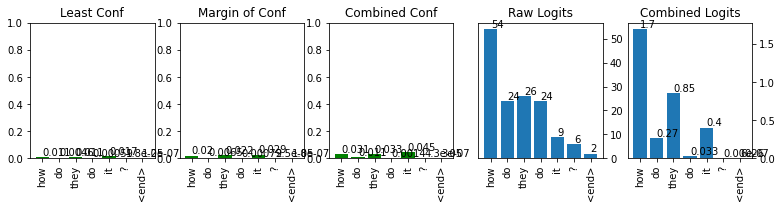



Target:  tom is out now .
Aggregate Score (mean): 21.0

Input: <start> תום עכשיו בחוץ . <end>
Predicted translation: tom is out now . <end> 
Runner-up translation: tom's now outside of now didn't 


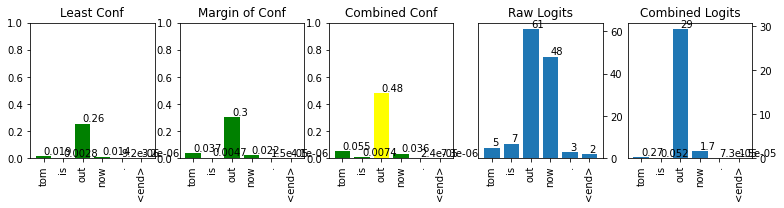



Target:  do you know him ?
Aggregate Score (mean): 21.166666666666668

Input: <start> את מכירה אותו ? <end>
Predicted translation: can you need him ? <end> 
Runner-up translation: do i find it out me 


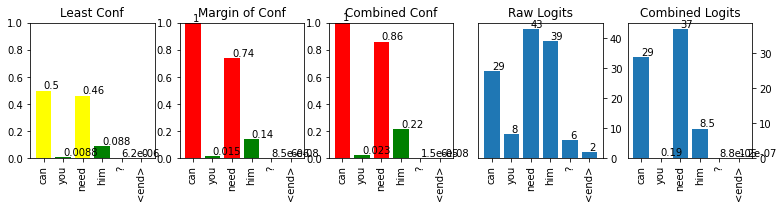



Target:  that'd do it .
Aggregate Score (mean): 21.2

Input: <start> זה יספיק . <end>
Predicted translation: that will do . <end> 
Runner-up translation: this would say do me 


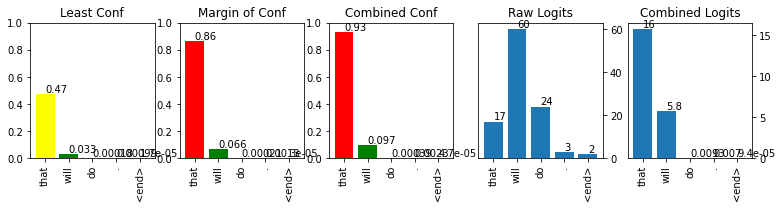



Target:  this is your fault .
Aggregate Score (mean): 21.4

Input: <start> אתה אשם ! <end>
Predicted translation: you're to go ! <end> 
Runner-up translation: you crazy work . go 


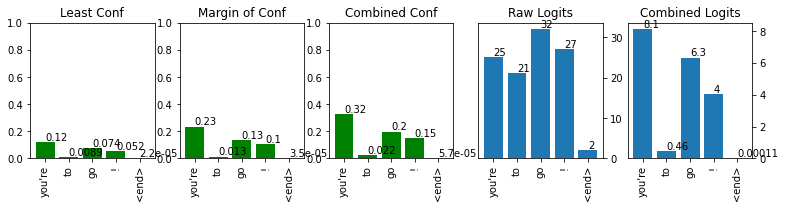



Target:  i know what to do .
Aggregate Score (mean): 21.428571428571427

Input: <start> אני יודע מה לעשות . <end>
Predicted translation: i know what to do . <end> 
Runner-up translation: i'm can what's i come well . 


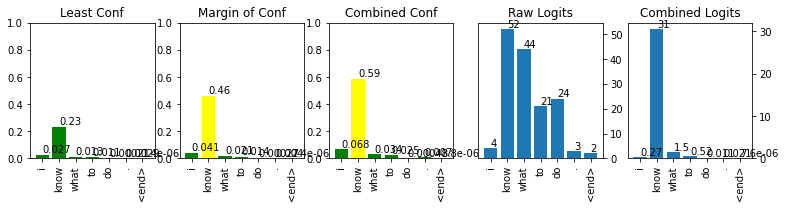



Target:  i made that for you .
Aggregate Score (mean): 21.714285714285715

Input: <start> עשיתי את זה בשבילך . <end>
Predicted translation: i did it for you . <end> 
Runner-up translation: i'll made this to free ! i 


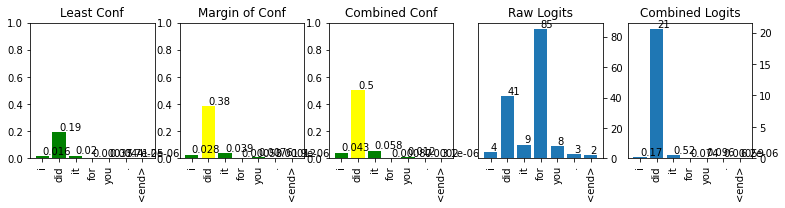



Target:  i hate tom .
Aggregate Score (mean): 22.0

Input: <start> אני שונא את תום . <end>
Predicted translation: i hate tom . <end> 
Runner-up translation: i've abhor everybody thing tom 


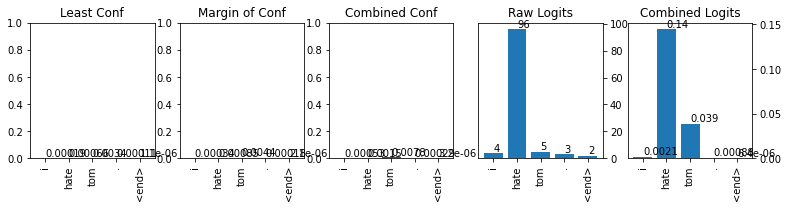



Target:  tom is undecided .
Aggregate Score (mean): 22.0

Input: <start> תום עוד לא החליט . <end>
Predicted translation: tom can't go . <end> 
Runner-up translation: he is say yet didn't 


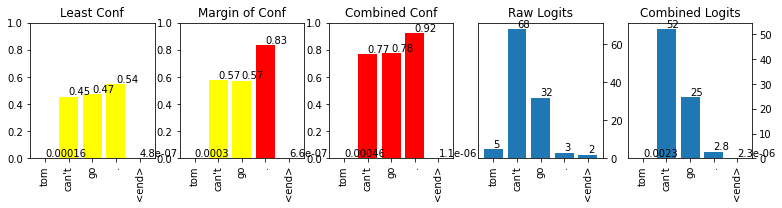



Target:  you want this ?
Aggregate Score (mean): 22.166666666666668

Input: <start> אתם רוצים את זה ? <end>
Predicted translation: do you want this ? <end> 
Runner-up translation: you they wanna it money you 


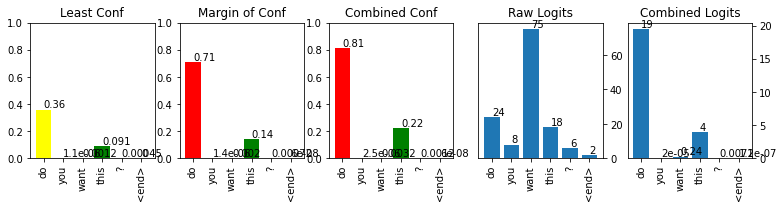



Target:  it's good training .
Aggregate Score (mean): 22.6

Input: <start> זה אימון טוב . <end>
Predicted translation: this is good . <end> 
Runner-up translation: that's good better training super 


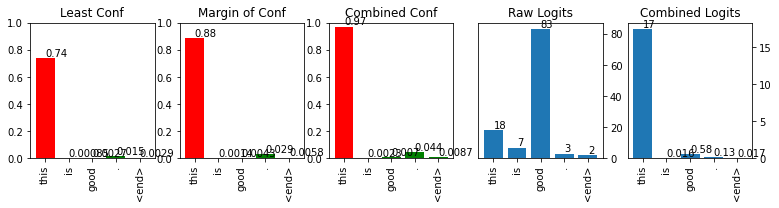



Target:  it's a good thing .
Aggregate Score (mean): 22.6

Input: <start> זה דבר טוב . <end>
Predicted translation: this is good . <end> 
Runner-up translation: that makes a good super 


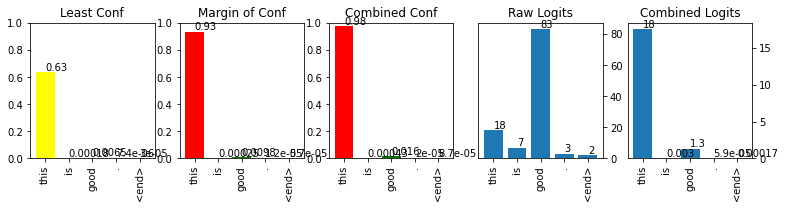



Target:  we want it .
Aggregate Score (mean): 22.8

Input: <start> אנו רוצים את זה . <end>
Predicted translation: we want this . <end> 
Runner-up translation: we've wanna that is . 


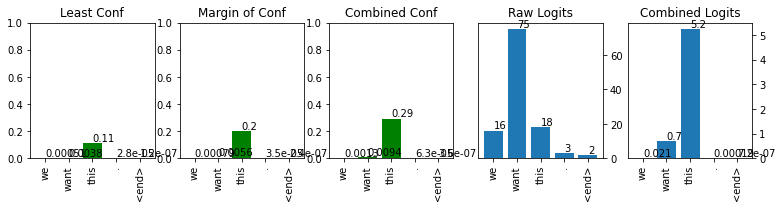



Target:  they want you dead .
Aggregate Score (mean): 22.8

Input: <start> הם רוצים שתמות . <end>
Predicted translation: they want you . <end> 
Runner-up translation: we wants to off . 


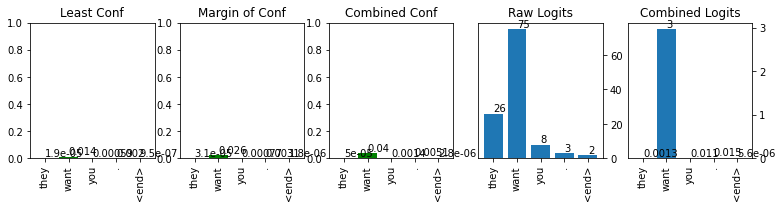



Target:  it's all i can do .
Aggregate Score (mean): 22.857142857142858

Input: <start> זה כל מה שאני יכולה לעשות . <end>
Predicted translation: it's all i can do . <end> 
Runner-up translation: that's so so could . it . 


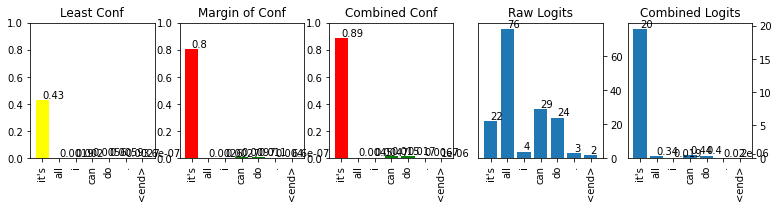



Target:  after you .
Aggregate Score (mean): 23.0

Input: <start> בבקשה , יופי לפני גיל . <end>
Predicted translation: please come to me . <end> 
Runner-up translation: wait work ! work ! super 


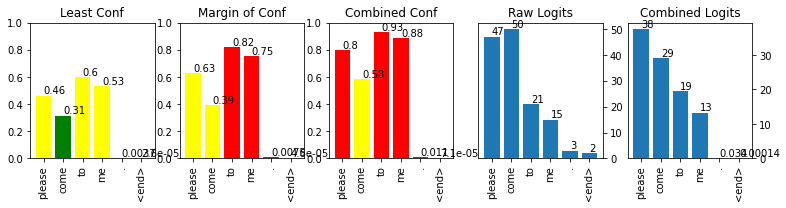



Target:  we're in no danger .
Aggregate Score (mean): 23.4

Input: <start> אנו לא בסכנה . <end>
Predicted translation: we're not in . <end> 
Runner-up translation: i'm out kidding danger . 


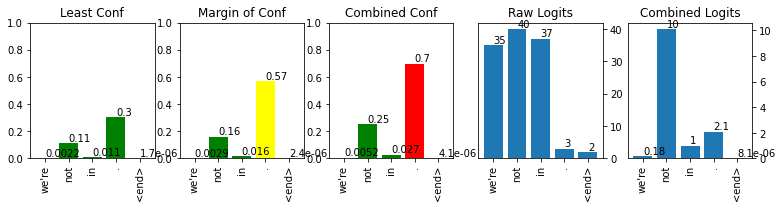



Target:  i just got up .
Aggregate Score (mean): 23.5

Input: <start> בדיוק קמתי . <end>
Predicted translation: i just got up . <end> 
Runner-up translation: you got left lost myself . 


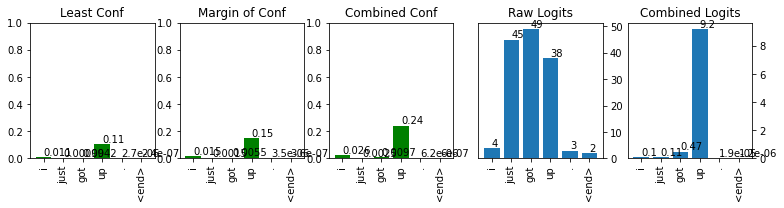



Target:  i've returned .
Aggregate Score (mean): 23.75

Input: <start> חזרתי . <end>
Predicted translation: i'm back . <end> 
Runner-up translation: i've late here super 


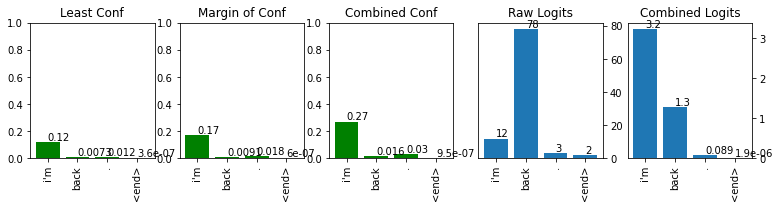



Target:  i'll come .
Aggregate Score (mean): 23.8

Input: <start> אבוא . <end>
Predicted translation: i will come . <end> 
Runner-up translation: i'm am go here . 


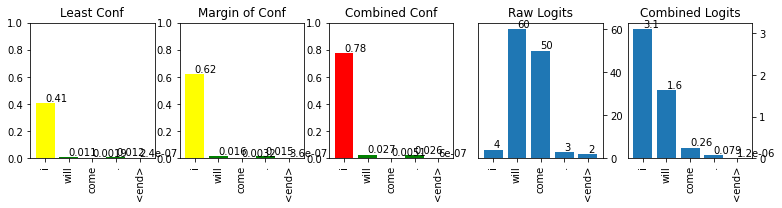



Target:  i hate that .
Aggregate Score (mean): 24.6

Input: <start> אני שונא את זה . <end>
Predicted translation: i hate this . <end> 
Runner-up translation: i've don't that ! i 


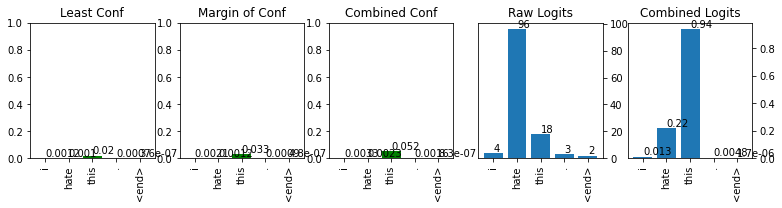



Target:  let me do it .
Aggregate Score (mean): 24.666666666666668

Input: <start> תן לי לעשות את זה . <end>
Predicted translation: let me do it . <end> 
Runner-up translation: leave it check that alone me 


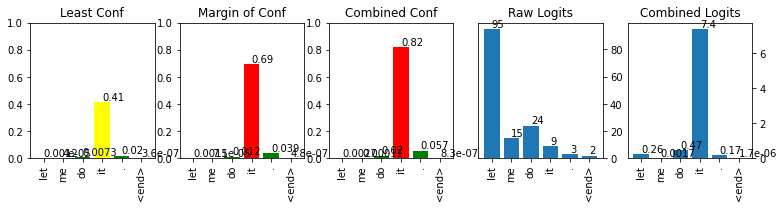



Target:  please come .
Aggregate Score (mean): 25.5

Input: <start> בוא בבקשה . <end>
Predicted translation: please come . <end> 
Runner-up translation: come go away everybody 


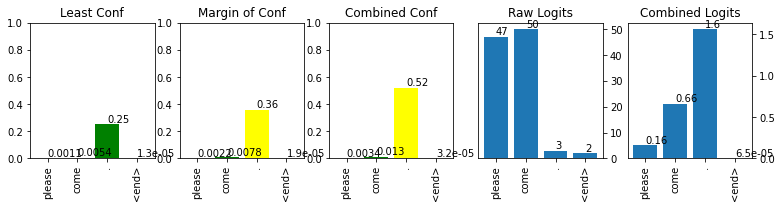



Target:  come on in , tom .
Aggregate Score (mean): 25.5

Input: <start> תיכנס , תום . <end>
Predicted translation: please come , tom . <end> 
Runner-up translation: move go in please , . 


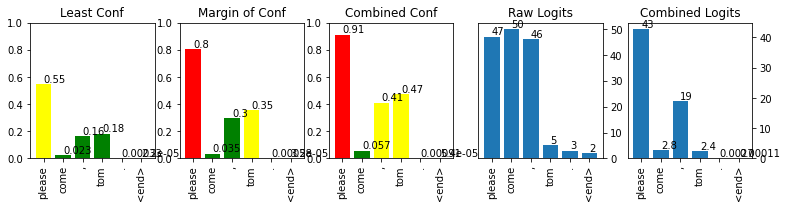



Target:  tom must do it now .
Aggregate Score (mean): 25.571428571428573

Input: <start> תום חייב לעשות את זה עכשיו . <end>
Predicted translation: tom must do it now . <end> 
Runner-up translation: he should be this . now didn't 


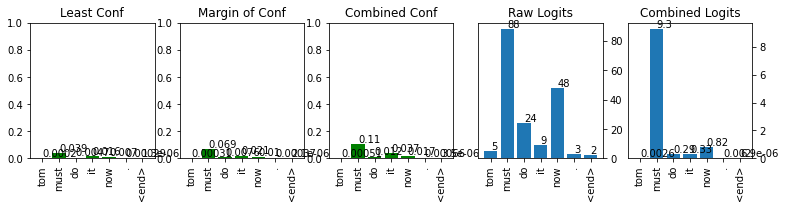



Target:  i know tom is right .
Aggregate Score (mean): 26.0

Input: <start> אני יודעת שתום צודק . <end>
Predicted translation: i know tom is right . <end> 
Runner-up translation: tom can tom's comes too now . 


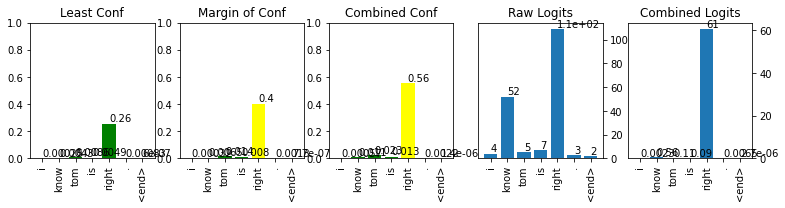



Target:  just take it .
Aggregate Score (mean): 26.4

Input: <start> רק תיקח את זה . <end>
Predicted translation: just take it . <end> 
Runner-up translation: only read that is . 


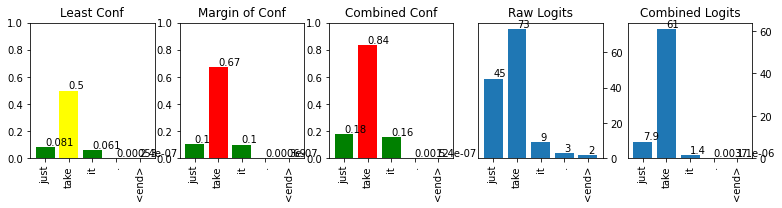



Target:  just enjoy it .
Aggregate Score (mean): 26.4

Input: <start> סתם תהנה מזה . <end>
Predicted translation: just take it . <end> 
Runner-up translation: it get that to it 


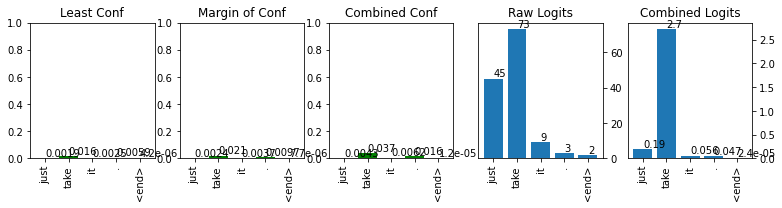

(array([], dtype=float64), array([], dtype=float64))

In [ ]:
get_ranked_uncertainty(val_information_means, 50, target_tensor_val, 
                       input_tensor=input_tensor_val, direction='ASCENDING', results=val_results)

Now we see some poor/incomplete translations, many also with high uncertainty, but not all of them.  So it seems that uncertainty due to a lack of information could be a used as another selection criterion, in addition to uncertainty due to competing information.




Target:  we're honeymooning .
Aggregate Score (mean): 1256.420361029799

Input: <start> אנו ביירח דבש . <end>
Predicted translation: we're bodybuilders . <end> 
Runner-up translation: we'll interfering down . 


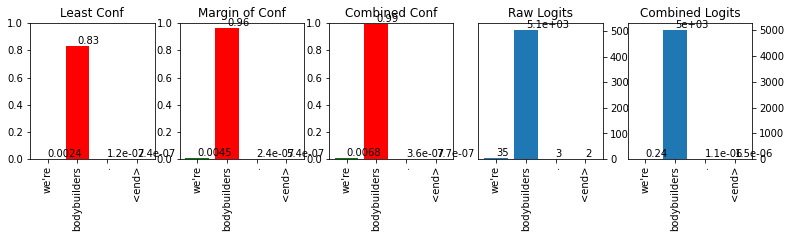



Target:  fish or cut bait .
Aggregate Score (mean): 1113.8017093726667

Input: <start> תדוג או תחתוך פתיונות . <end>
Predicted translation: my ear is imminent . <end> 
Runner-up translation: slide arms itches cheap ! didn't 


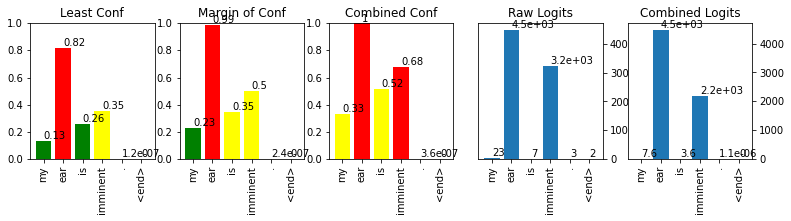



Target:  cherish this moment .
Aggregate Score (mean): 1113.125552728027

Input: <start> הוקיר את הרגע . <end>
Predicted translation: cherish the shirt . <end> 
Runner-up translation: write this nail down myself 


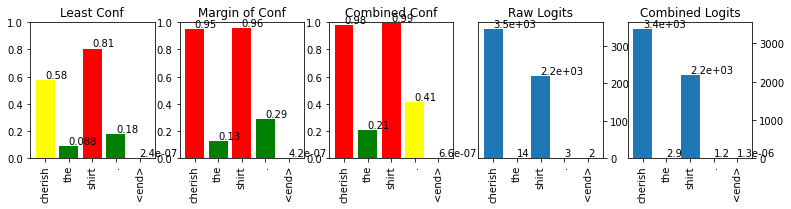



Target:  it was night .
Aggregate Score (mean): 966.0551870726049

Input: <start> זו הייתה שעת לילה . <end>
Predicted translation: it was spectacular . <end> 
Runner-up translation: that has perfect night didn't 


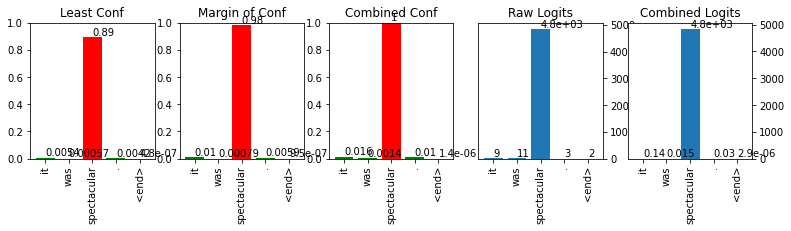



Target:  shoes are required .
Aggregate Score (mean): 946.4946655152365

Input: <start> צריך נעלים . <end>
Predicted translation: you've got rhythm . <end> 
Runner-up translation: we'll has rules are fire 


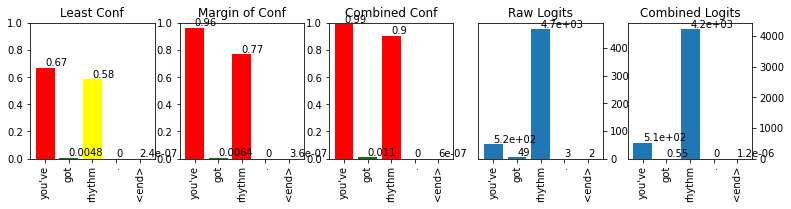



Target:  copy this file .
Aggregate Score (mean): 919.0341960832477

Input: <start> העתק את הקובץ הזה . <end>
Predicted translation: rugs this box . <end> 
Runner-up translation: copy that area later . 


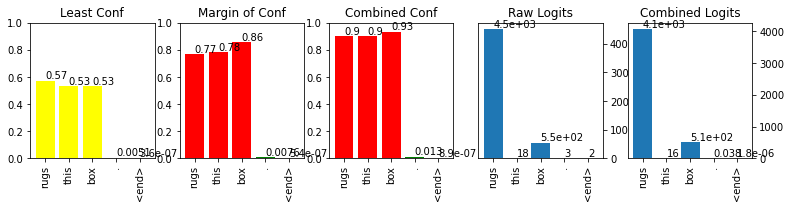



Target:  tom looks hopeful .
Aggregate Score (mean): 885.7569812446833

Input: <start> תום נראה מלא תקוה . <end>
Predicted translation: tom looks hopeful . <end> 
Runner-up translation: mary seems his off . 


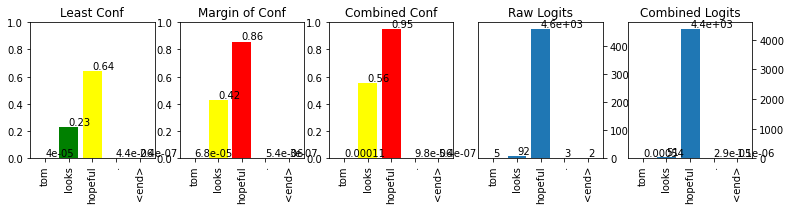



Target:  dinner is served .
Aggregate Score (mean): 875.8873303136788

Input: <start> ארוחת הערב מוגשת . <end>
Predicted translation: dinner's great . <end> 
Runner-up translation: dinner lunch ! super 


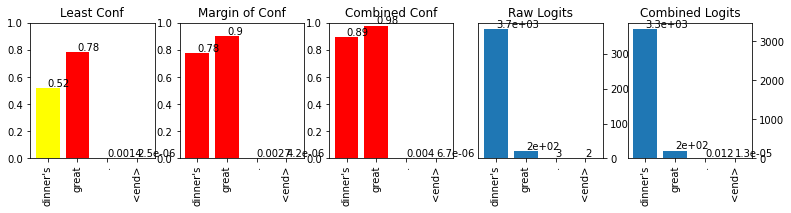



Target:  i took a walk .
Aggregate Score (mean): 871.9159588947892

Input: <start> צעדתי . <end>
Predicted translation: i stepped promising . <end> 
Runner-up translation: i've improvised down ! didn't 


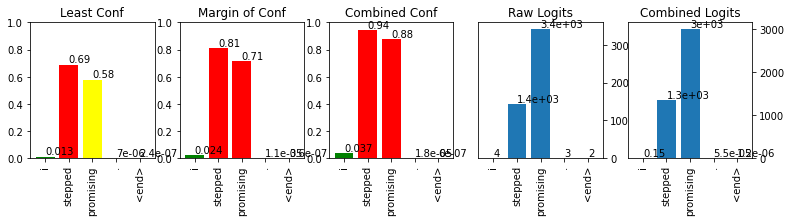



Target:  it's free of charge .
Aggregate Score (mean): 868.9679491865439

Input: <start> זה ללא תשלום . <end>
Predicted translation: it's part of charge . <end> 
Runner-up translation: it my . food ! didn't 


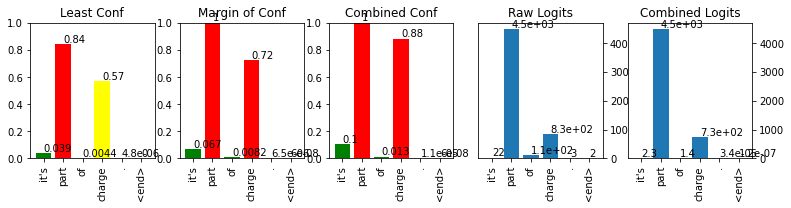

(array([], dtype=float64), array([], dtype=float64))

In [ ]:
get_ranked_uncertainty(val_combined_means, 10, target_tensor_val, 
                       input_tensor=input_tensor_val, direction='DESCENDING', results=val_results)

Here where we combine competing uncertainty with high information content, we often find some pretty bad word translations for less common vocabulary (i.e. higher information content)  like "baker" for "musician", or "bodybuilders" for "honeymooners".  This can be a good way to sample for these types of errors.

##Confirming that Scores do successfully model Accuracy Confidence

So our thresholds we chose to do some exploratory analysis were arbitrary:

In [ ]:
import scipy as sp
high_uncertainty_threshold_percentile = sp.stats.percentileofscore(val_sequences_means, uncertainty_sampling_treshold)
print ("Percentile of our high uncertainty threshold for validation scores: " + str(high_uncertainty_threshold_percentile))

Percentile of our high uncertainty threshold for validation scores: 97.7


Let's try to do a more formal job in exploring competition uncertainty as a predictor for potential errors, using a range percentile thresholds instead:

In [ ]:
val_total_matches, val_total_non_matches = get_ranked_uncertainty(val_sequences_means, total_test_size, target_tensor_val,
                                              direction='ASCENDING', display=False, results=val_results)
print("Total Validation set matches: " + str(len(val_total_matches)))
print("Validation set non-Matches: " + str(len(val_total_non_matches)))
print("Matching: {:.1%}".format((len(val_total_matches)/(len(val_total_matches)+len(val_total_non_matches)))))

Total Validation set matches: 456
Validation set non-Matches: 544
Matching: 45.6%


Depending on the validation set, non-match percentages can vary widely, both very much above and very much below 50%.  If much above 50%, non-matches will tend to be concentrated in the high-uncertainty percentiles much more than if not.  If below 50%, we'll want to still use analysis sampling from different percentile ranges.  

In [ ]:
def find_uncertainty_predictivity(sequence_scores = val_sequences_means, percentile=90): #higher the percentile, higher the uncertainty
  percentile_threshold = np.percentile(sequence_scores, percentile)
  print("Percentile score threshold: " + str(percentile_threshold))
  #first_decile = [v for v in val_sequences_means if v <= tenth_percentile]
  percentile_len = total_test_size*(100-percentile)//100
  #print(val_sequences_means)

  percentile_matches, percentile_non_matches = get_ranked_uncertainty(val_sequences_means, percentile_len, target_tensor_val, 
                       input_tensor=input_tensor_val, direction='DESCENDING', display=False, results=val_results)
  print("Matches for the " + str(percentile) + "th percentile: " + str(len(percentile_matches)))
  print("Non-Matches for the " + str(percentile) + "th percentile: " + str(len(percentile_non_matches)))
  print("Non-Matching: {:.1%}".format((len(percentile_non_matches)/(len(percentile_matches)+len(percentile_non_matches)))))
  print("\033[1m{:.1%}\033[0m".format(len(percentile_non_matches)/(len(val_total_non_matches))) +
        " of the potential errors are found by \033[1m{:.1%}\033[0m".format((100-percentile)/100) +
        " of the target sentences with the highest uncertainty score.")
  #return val_percentile_matches, val_percentile_non_matches

So now we have our validation set matches, (i.e. known to be accurate because they match), and non-matches (potential errors in prediction). Let's try to find out how uncertainty scoring can predict the non-matches, (and therefore, potential errors), by stepping 10 percentiles (deciles):

In [ ]:
print("Total validation non-matches: " + str(len(val_total_non_matches)))
find_uncertainty_predictivity(percentile=90)

Total validation non-matches: 544
Percentile score threshold: 0.3649617013335228
Matches for the 90th percentile: 3
Non-Matches for the 90th percentile: 97
Non-Matching: 97.0%
17.8% of the potential errors are found by 10.0% of the target sentences with the highest uncertainty score.


In [ ]:
find_uncertainty_predictivity(percentile=80)

Percentile score threshold: 0.2790813723330696
Matches for the 80th percentile: 17
Non-Matches for the 80th percentile: 183
Non-Matching: 91.5%
33.6% of the potential errors are found by 20.0% of the target sentences with the highest uncertainty score.


In [ ]:
find_uncertainty_predictivity(percentile=70)

Percentile score threshold: 0.21855679189165428
Matches for the 70th percentile: 50
Non-Matches for the 70th percentile: 250
Non-Matching: 83.3%
46.0% of the potential errors are found by 30.0% of the target sentences with the highest uncertainty score.


In [ ]:
find_uncertainty_predictivity(percentile=20)

Percentile score threshold: 0.02484153509140015
Matches for the 20th percentile: 309
Non-Matches for the 20th percentile: 491
Non-Matching: 61.4%
90.3% of the potential errors are found by 80.0% of the target sentences with the highest uncertainty score.


In [ ]:
find_uncertainty_predictivity(percentile=10)

Percentile score threshold: 0.008982854684193929
Matches for the 10th percentile: 375
Non-Matches for the 10th percentile: 525
Non-Matching: 58.3%
96.5% of the potential errors are found by 90.0% of the target sentences with the highest uncertainty score.


So it looks like the trend is clear, (not very dramatically for some validation sets), that the higher the uncertainty, the higher the potential errors (mismatches to reference translation). 
Let's dive into sampling and look at the mismatches in different deciles:

In [ ]:
def show_mismatches_in_percentile_range_results(low_percentile, high_percentile, sequence_scores = val_sequences_means, number_to_display=None):
  low_percentile_threshold = np.percentile(sequence_scores, low_percentile)
  high_percentile_threshold = np.percentile(sequence_scores, high_percentile)
  print("Low Percentile score threshold: " + str(low_percentile_threshold))
  print("High Percentile score threshold: " + str(high_percentile_threshold))
  #print(len(val_sequences_means))
  percentile_results = [list(sequence_scores).index(v) for v in sequence_scores if v > low_percentile_threshold 
                                                                                if v <= high_percentile_threshold]
  #print(percentile_results)    
  #get_ranked_uncertainty(training_sequences_means, len(training_non_matches), target_tensor_train, 
  #                     input_tensor=input_tensor_train, ranking=training_non_matches, results=training_results)                                                            
  percentile_range_matches, percentile_range_non_matches = get_ranked_uncertainty(sequence_scores, len(percentile_results), target_tensor_val, 
                       input_tensor=input_tensor_val, ranking=percentile_results, direction='DESCENDING', display=False, results=val_results)
  if not number_to_display:
    number_to_display = len(percentile_range_non_matches)
  get_ranked_uncertainty(sequence_scores, number_to_display, target_tensor_val, 
                       input_tensor=input_tensor_val, ranking=percentile_range_non_matches, results=val_results)

**High Uncertainty -> Low Accuracy**:

Low Percentile score threshold: 0.3649617013335228
High Percentile score threshold: 0.6577186822891236


Target:  dinner is served .
Aggregate Score (mean): 0.4682800709269941

Input: <start> ארוחת הערב מוגשת . <end>
Predicted translation: dinner's great . <end> 
Runner-up translation: dinner lunch ! super 


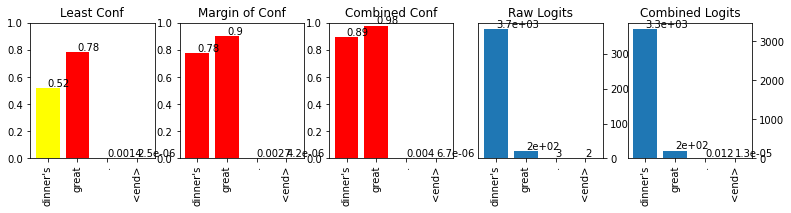



Target:  i'm sorry you lost .
Aggregate Score (mean): 0.5558371876499483

Input: <start> אני מצטערת שהפסדת . <end>
Predicted translation: i'm afraid to the zoo . <end> 
Runner-up translation: i'll suspicious you lost car ! me 


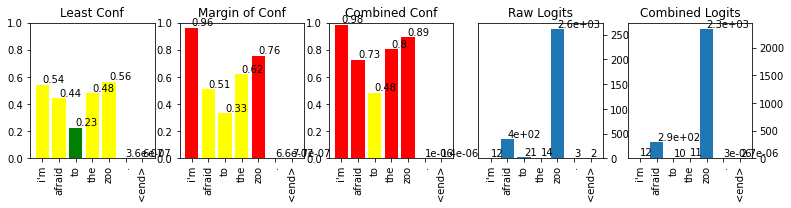



Target:  i am from brazil .
Aggregate Score (mean): 0.4123188376426697

Input: <start> מוצאי מברזיל . <end>
Predicted translation: i've got time . <end> 
Runner-up translation: i gotten more , super 


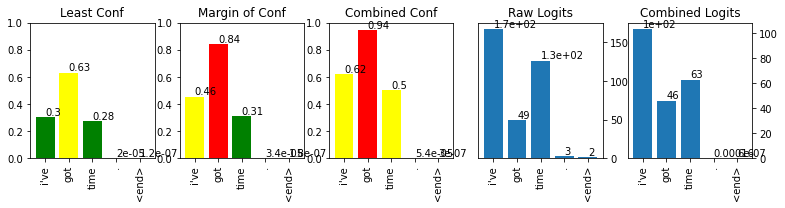



Target:  tom came close .
Aggregate Score (mean): 0.3706079158000648

Input: <start> תום כמעט עבר . <end>
Predicted translation: tom almost is through . <end> 
Runner-up translation: tom's is died simple ! . 


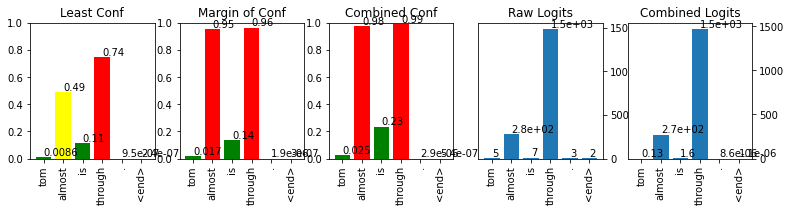



Target:  call me sometime .
Aggregate Score (mean): 0.4218401897698641

Input: <start> טלפן מדי פעם . <end>
Predicted translation: love is quiet . <end> 
Runner-up translation: play tom's once down . 


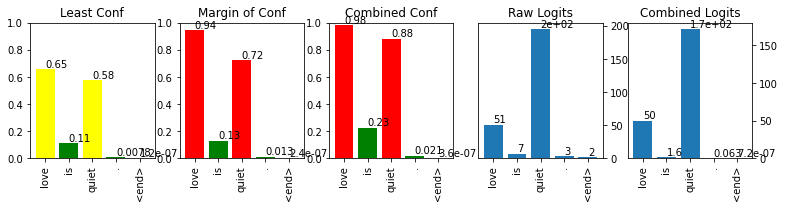



Target:  who else was there ?
Aggregate Score (mean): 0.5918581798672676

Input: <start> מי עוד היה שם ? <end>
Predicted translation: who was there ? <end> 
Runner-up translation: who's is over , ? 


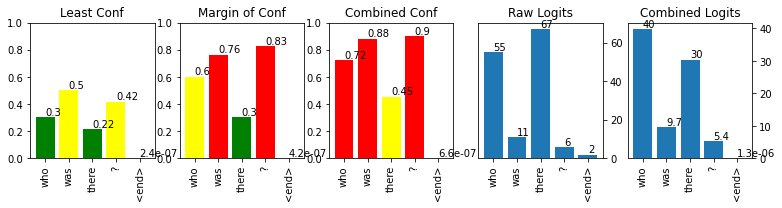



Target:  just let tom in .
Aggregate Score (mean): 0.404700147608916

Input: <start> פשוט תן לתום להכנס . <end>
Predicted translation: just stop it in . <end> 
Runner-up translation: it let that . once . 


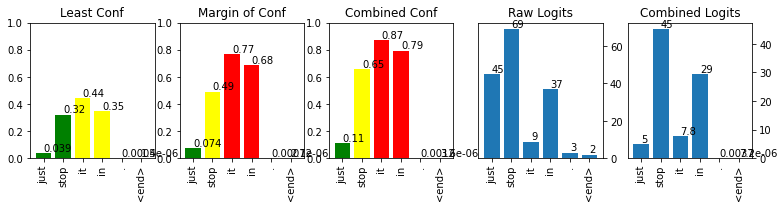



Target:  we must intervene .
Aggregate Score (mean): 0.4942531227134168

Input: <start> אנו חייבים להתערב . <end>
Predicted translation: we have turned problems . <end> 
Runner-up translation: we'll got intervene . tire . 


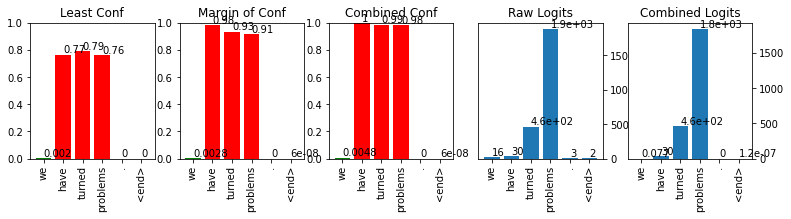



Target:  he failed the exam .
Aggregate Score (mean): 0.4548103487274299

Input: <start> הוא נכשל בבחינה . <end>
Predicted translation: he has a shout . <end> 
Runner-up translation: tom got the flu on . 


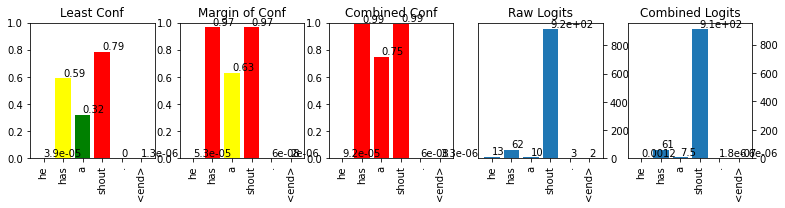



Target:  we prayed for rain .
Aggregate Score (mean): 0.42440434638410807

Input: <start> התפללנו לגשם . <end>
Predicted translation: we prayed from rain . <end> 
Runner-up translation: it's got for tom off didn't 


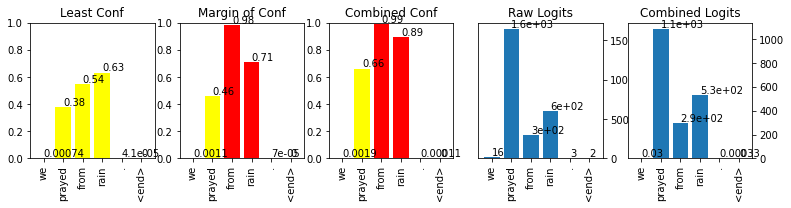



Target:  what is a ufo ?
Aggregate Score (mean): 0.392171853354999

Input: <start> מב זה עב מ ? <end>
Predicted translation: what is it a lot ? <end> 
Runner-up translation: what's a a miss blanket it me 


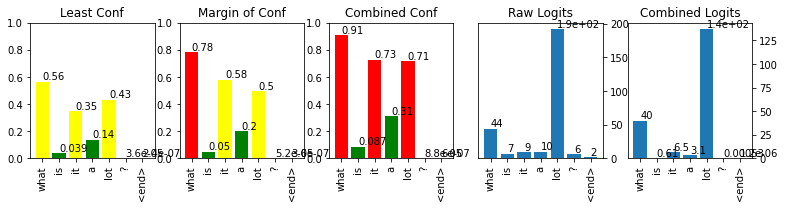



Target:  let's all do it .
Aggregate Score (mean): 0.40080276113003493

Input: <start> בואו נעשה זאת כולנו . <end>
Predicted translation: let's we all . <end> 
Runner-up translation: thanks everyone do home . 


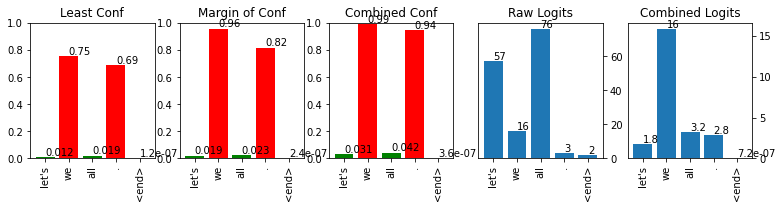



Target:  i wrote it all down .
Aggregate Score (mean): 0.4173360500484705

Input: <start> רשמתי את כל זה . <end>
Predicted translation: i wrote that . <end> 
Runner-up translation: i've write it bag i 


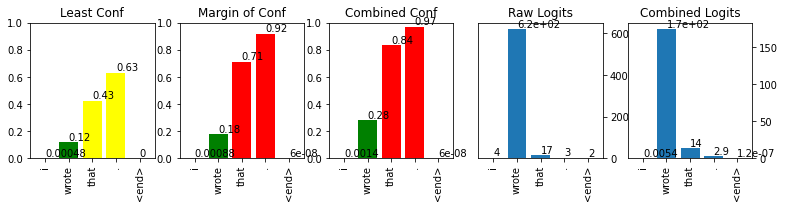



Target:  i wasn't offended .
Aggregate Score (mean): 0.39376557767391207

Input: <start> לא נעלבתי . <end>
Predicted translation: i didn't listen . <end> 
Runner-up translation: i'm wasn't give out didn't 


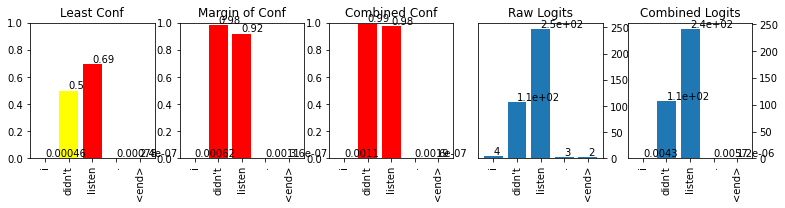



Target:  i guess we could .
Aggregate Score (mean): 0.4521522186114453

Input: <start> אני מעריך שאנחנו יכולים . <end>
Predicted translation: i dream ? <end> 
Runner-up translation: i'm borrow eat . 


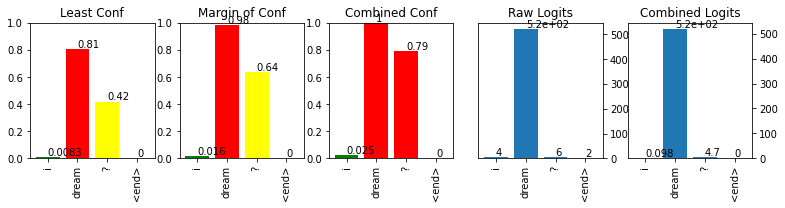

In [ ]:
show_mismatches_in_percentile_range_results(90, 100, number_to_display=15)

**Low Uncertainty -> High Accuracy (even if mismatched with reference translation)**

Low Percentile score threshold: 0.00023068487644195557
High Percentile score threshold: 0.008982854684193929


Target:  tom trusted mary .
Aggregate Score (mean): 0.004008998473485311

Input: <start> תום סמך על מרי . <end>
Predicted translation: tom relied on mary . <end> 
Runner-up translation: he trusted mary his down . 


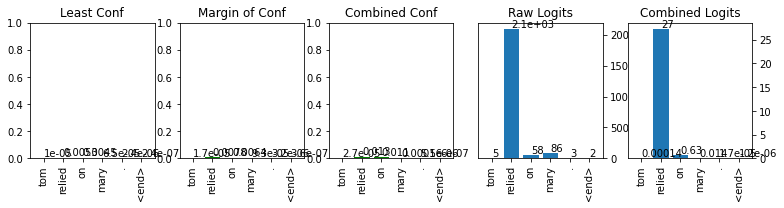



Target:  clean it up .
Aggregate Score (mean): 0.0077196240425109865

Input: <start> תנקי את זה . <end>
Predicted translation: clean that up . <end> 
Runner-up translation: turn it down ! . 


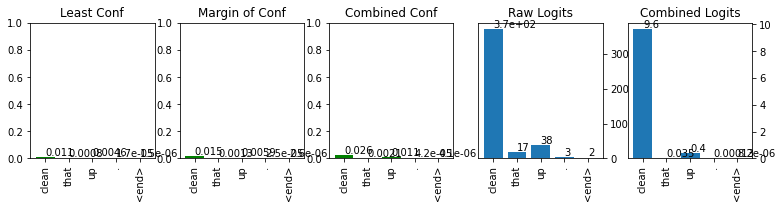



Target:  they're amazing .
Aggregate Score (mean): 0.005678549408912659

Input: <start> הם מדהימים . <end>
Predicted translation: they're cool . <end> 
Runner-up translation: they gorgeous is . 


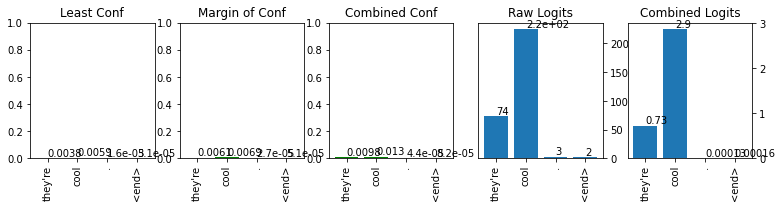



Target:  are you faithful ?
Aggregate Score (mean): 0.0035606861114501954

Input: <start> אתה נאמן ? <end>
Predicted translation: are you loyal ? <end> 
Runner-up translation: is those energetic you ? 


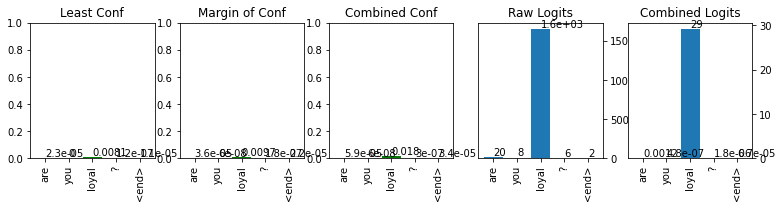



Target:  tom saw somebody .
Aggregate Score (mean): 0.0051509618759155275

Input: <start> תום ראה מישהו . <end>
Predicted translation: tom saw someone . <end> 
Runner-up translation: they gave mary was . 


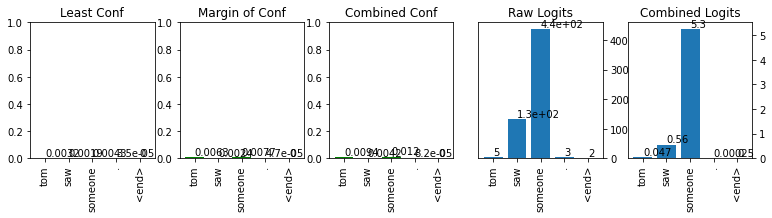



Target:  have you met him ?
Aggregate Score (mean): 0.0070168375968933105

Input: <start> האם פגשת אותו ? <end>
Predicted translation: did you meet him ? <end> 
Runner-up translation: was i warn tom . me 


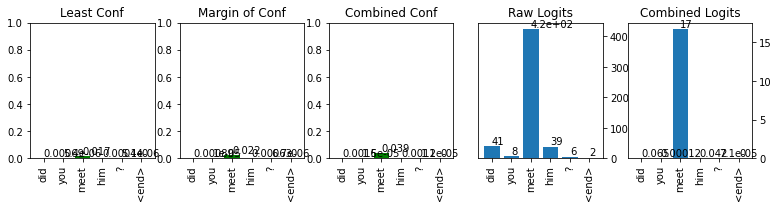



Target:  school's out .
Aggregate Score (mean): 0.004518532752990722

Input: <start> בית הספר נגמר . <end>
Predicted translation: school is over . <end> 
Runner-up translation: his , her ! . 


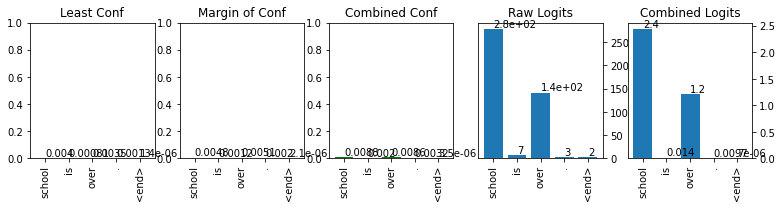



Target:  tom never showed .
Aggregate Score (mean): 0.006021042664845784

Input: <start> תום אף פעם לא הופיע . <end>
Predicted translation: tom never showed up . <end> 
Runner-up translation: he walked returned . ! didn't 


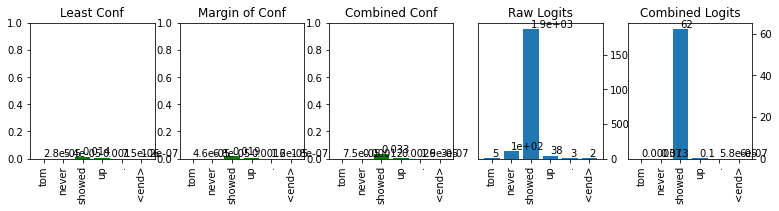



Target:  i'm hardworking .
Aggregate Score (mean): 0.00789003074169159

Input: <start> אני חרוץ . <end>
Predicted translation: i'm diligent . <end> 
Runner-up translation: it's conservative ? i 


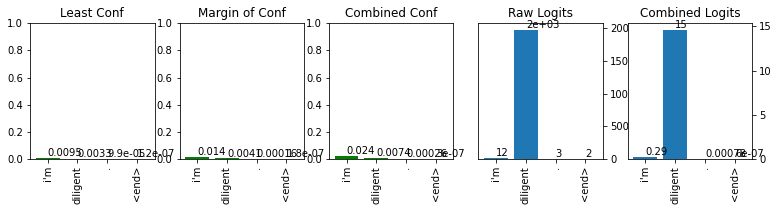



Target:  you're harsh .
Aggregate Score (mean): 0.006621137261390686

Input: <start> את קשוחה . <end>
Predicted translation: you're tough . <end> 
Runner-up translation: now arrogant ! . 


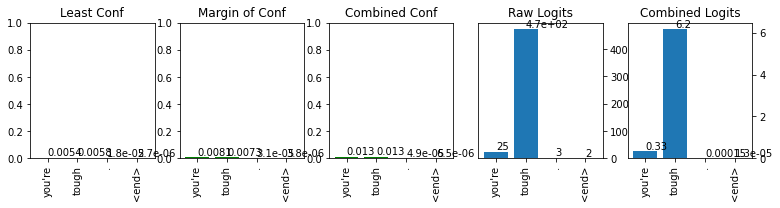



Target:  tom was suspended .
Aggregate Score (mean): 0.0023304343223571776

Input: <start> טום הושעה . <end>
Predicted translation: tom got suspended . <end> 
Runner-up translation: tom's has a up . 


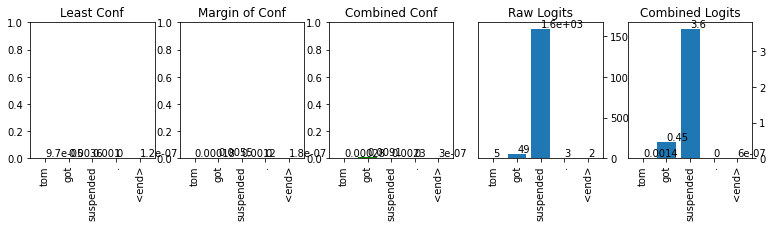



Target:  tom laughed loudly .
Aggregate Score (mean): 0.006529533863067627

Input: <start> תום צחק בקול . <end>
Predicted translation: tom laughed aloud . <end> 
Runner-up translation: they spoke . loudly didn't 


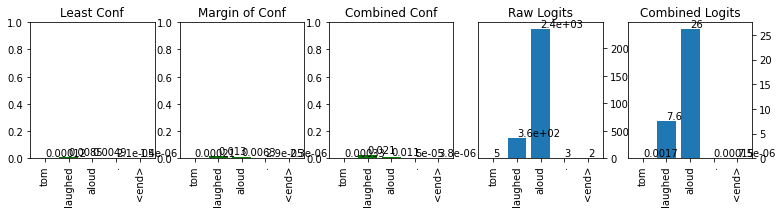



Target:  i'm a salesperson .
Aggregate Score (mean): 0.004842674732208252

Input: <start> אני איש מכירות . <end>
Predicted translation: i'm a salesman . <end> 
Runner-up translation: it's an casanova man . 


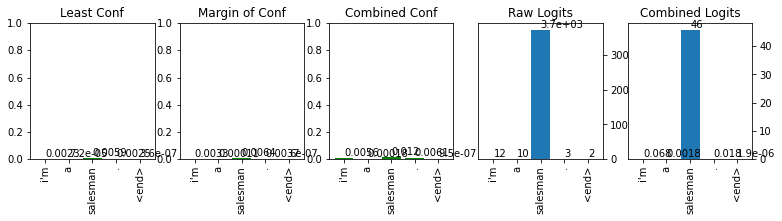



Target:  her eyes are blue .
Aggregate Score (mean): 0.00488703449567159

Input: <start> יש לה עיניים כחולות . <end>
Predicted translation: she has blue eyes . <end> 
Runner-up translation: she's eyes a . are . 


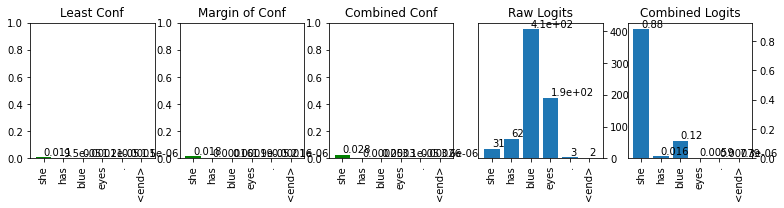



Target:  i'm back .
Aggregate Score (mean): 0.007655775547027588

Input: <start> שבתי . <end>
Predicted translation: i came back . <end> 
Runner-up translation: i've will in time . 


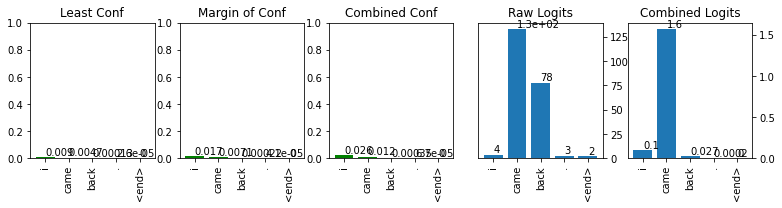

In [ ]:
show_mismatches_in_percentile_range_results(0,10,number_to_display=15)

In [ ]:
#show_mismatches_in_percentile_range_results(90, 100, sequence_scores = val_combined_means, number_to_display=15)

## Conclusion and Thanks!
The above confirms the hypothesis that these scores can be used for modelling not only uncertainty, but acuracy, and drive further analysis and uncertainty sampling iterations. 


**Some next steps:**
  - ignore end of sentence token for aggregate certainty score
  - try Entropy score? - not sure that will tell us more than what we have here but may surprise us
  - try longer sentences
  - try different base in a custom softmax function (per Robert Munro)
  - Reverse source and target (non-English targets)
  - try aggregation by minimum token confidence in sequence
  - use another algorithm (e.g. Transformers)

